In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats

import missingno

from feature_engine.transformation import YeoJohnsonTransformer
from feature_engine.transformation import BoxCoxTransformer
from feature_engine.transformation import ArcsinTransformer

import warnings
warnings.filterwarnings("ignore")

# Load data

In [2]:
data = pd.read_csv("loan_data_2007_2014.csv", index_col = [0], dtype = {"desc" : str})

print(data.shape)

data.head()

(466285, 74)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 466285 entries, 0 to 466284
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           466285 non-null  int64  
 1   member_id                    466285 non-null  int64  
 2   loan_amnt                    466285 non-null  int64  
 3   funded_amnt                  466285 non-null  int64  
 4   funded_amnt_inv              466285 non-null  float64
 5   term                         466285 non-null  object 
 6   int_rate                     466285 non-null  float64
 7   installment                  466285 non-null  float64
 8   grade                        466285 non-null  object 
 9   sub_grade                    466285 non-null  object 
 10  emp_title                    438697 non-null  object 
 11  emp_length                   445277 non-null  object 
 12  home_ownership               466285 non-null  object 
 13 

# Data cleaning

* it seems like some variables has only missing values as their values. this variables will be dropped.
* variables with each value is unique (constant) will be dropped.

## missing value

* variables with all missing value will be removed.

In [4]:
data = data.replace({None: np.nan})

In [5]:
all_vars_na = [col for col in data.columns if data[col].isna().sum() == len(data)]
print(f"Number of all varibles na : {len(all_vars_na)}")

all_vars_na

Number of all varibles na : 17


['annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'open_acc_6m',
 'open_il_6m',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m']

In [6]:
# drop variables all_vars_na
data.drop(all_vars_na, axis = 1, inplace = True)

In [7]:
data.shape

(466285, 57)

## cardinality

* variables have 100% unique values will be removed.

In [8]:
all_vars_unique = data.nunique()
all_vars_unique = all_vars_unique[all_vars_unique == len(data)].index
print(f"Number of all varibles unique : {len(all_vars_unique)}")
all_vars_unique

Number of all varibles unique : 3


Index(['id', 'member_id', 'url'], dtype='object')

when we have no duplicate value on `id` or `member id`, it is mean that there is no duplicate data.

In [9]:
# dropped
data.drop(all_vars_unique, axis = 1, inplace = True)

In [10]:
data.shape

(466285, 54)

# Data Analysis

In [11]:
vars_cat = [col for col in data.columns if data[col].dtypes == "O"]
vars_num = [col for col in data.columns if data[col].dtypes != "O"]

In [12]:
print(f"Numbers of categorical variables : {len(vars_cat)}")
print(f"Numbers of numerical variables : {len(vars_num)}")

Numbers of categorical variables : 21
Numbers of numerical variables : 33


## Target Variables

In [13]:
target = "loan_status"

data["loan_status"].value_counts().sort_values(ascending = False)

Current                                                224226
Fully Paid                                             184739
Charged Off                                             42475
Late (31-120 days)                                       6900
In Grace Period                                          3146
Does not meet the credit policy. Status:Fully Paid       1988
Late (16-30 days)                                        1218
Default                                                   832
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

In [14]:
target_map = {
    "Current" : "good"
    , "Fully Paid" : "good"
    , "Charged Off" : "bad"
    , "Default" : "bad"
    , "Late (31-120 days)" : "bad"
    , "Does not meet the credit policy. Status:Charged Off" : "bad"
}

data = data[data["loan_status"].isin([
    "Current"
    , "Fully Paid"
    , "Charged Off"
    , "Default"
    , "Late (31-120 days)"
    , "Does not meet the credit policy. Status:Charged Off"
])]

data["loan_status"] = data["loan_status"].map(target_map)

In [15]:
data.shape

(459933, 54)

In [16]:
data["loan_status"].value_counts(normalize = True)

good    0.889184
bad     0.110816
Name: loan_status, dtype: float64

## Numerical Variables

### Missing Values

In [17]:
vars_num_with_na = [col for col in vars_num if data[col].isna().sum() > 0]
print(f"Numbers of numerical variables with Na : {len(vars_num_with_na)}")

Numbers of numerical variables with Na : 14


In [18]:
# percentage

data[vars_num_with_na].isna().mean().sort_values(ascending = False)

mths_since_last_record         0.866465
mths_since_last_major_derog    0.787523
mths_since_last_delinq         0.538070
tot_coll_amt                   0.148272
tot_cur_bal                    0.148272
total_rev_hi_lim               0.148272
revol_util                     0.000659
collections_12_mths_ex_med     0.000170
delinq_2yrs                    0.000007
inq_last_6mths                 0.000007
open_acc                       0.000007
pub_rec                        0.000007
total_acc                      0.000007
acc_now_delinq                 0.000007
dtype: float64

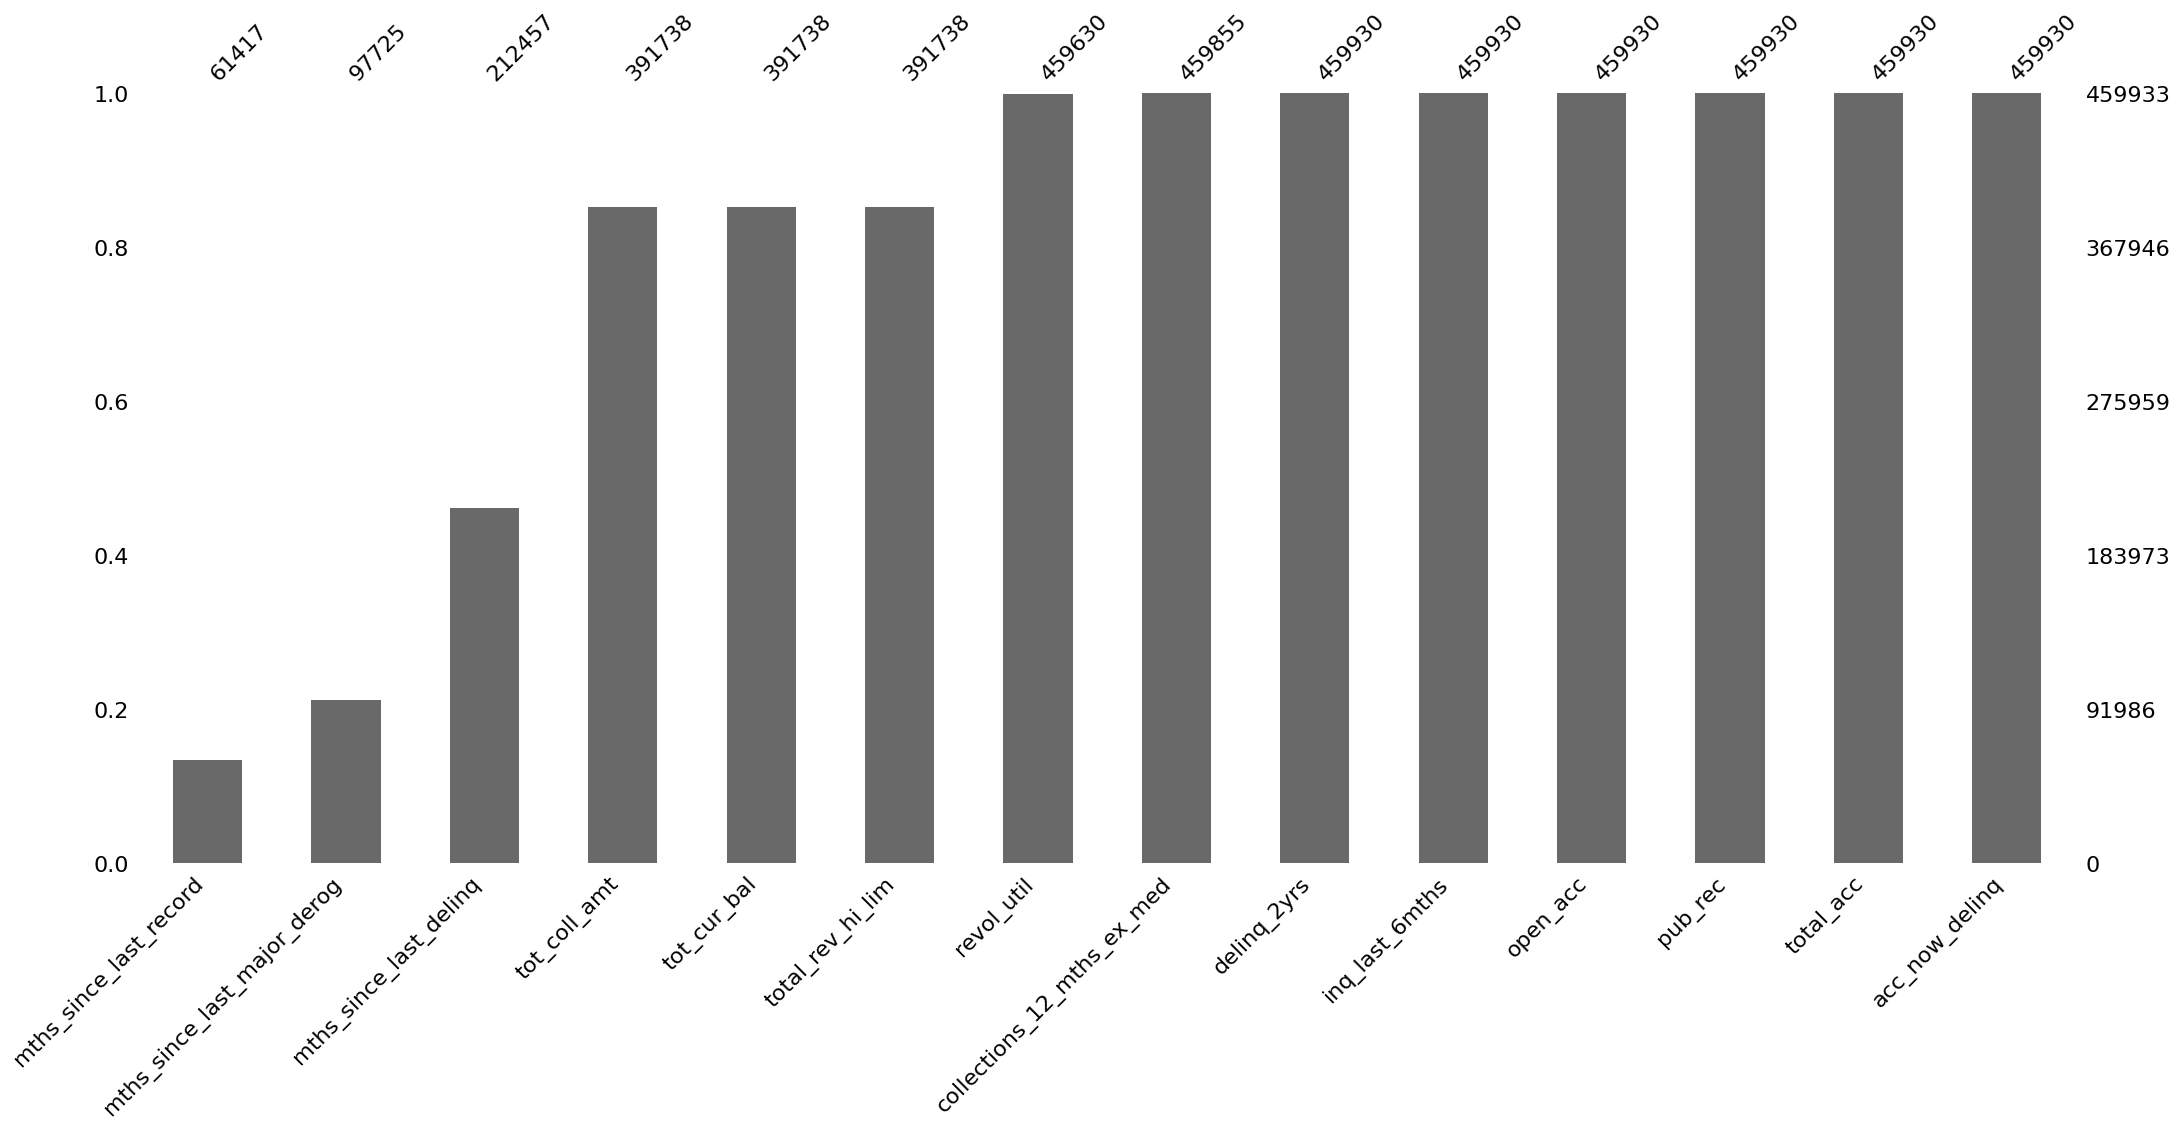

In [19]:
missingno.bar(data[vars_num_with_na], sort = "ascending")
plt.show()

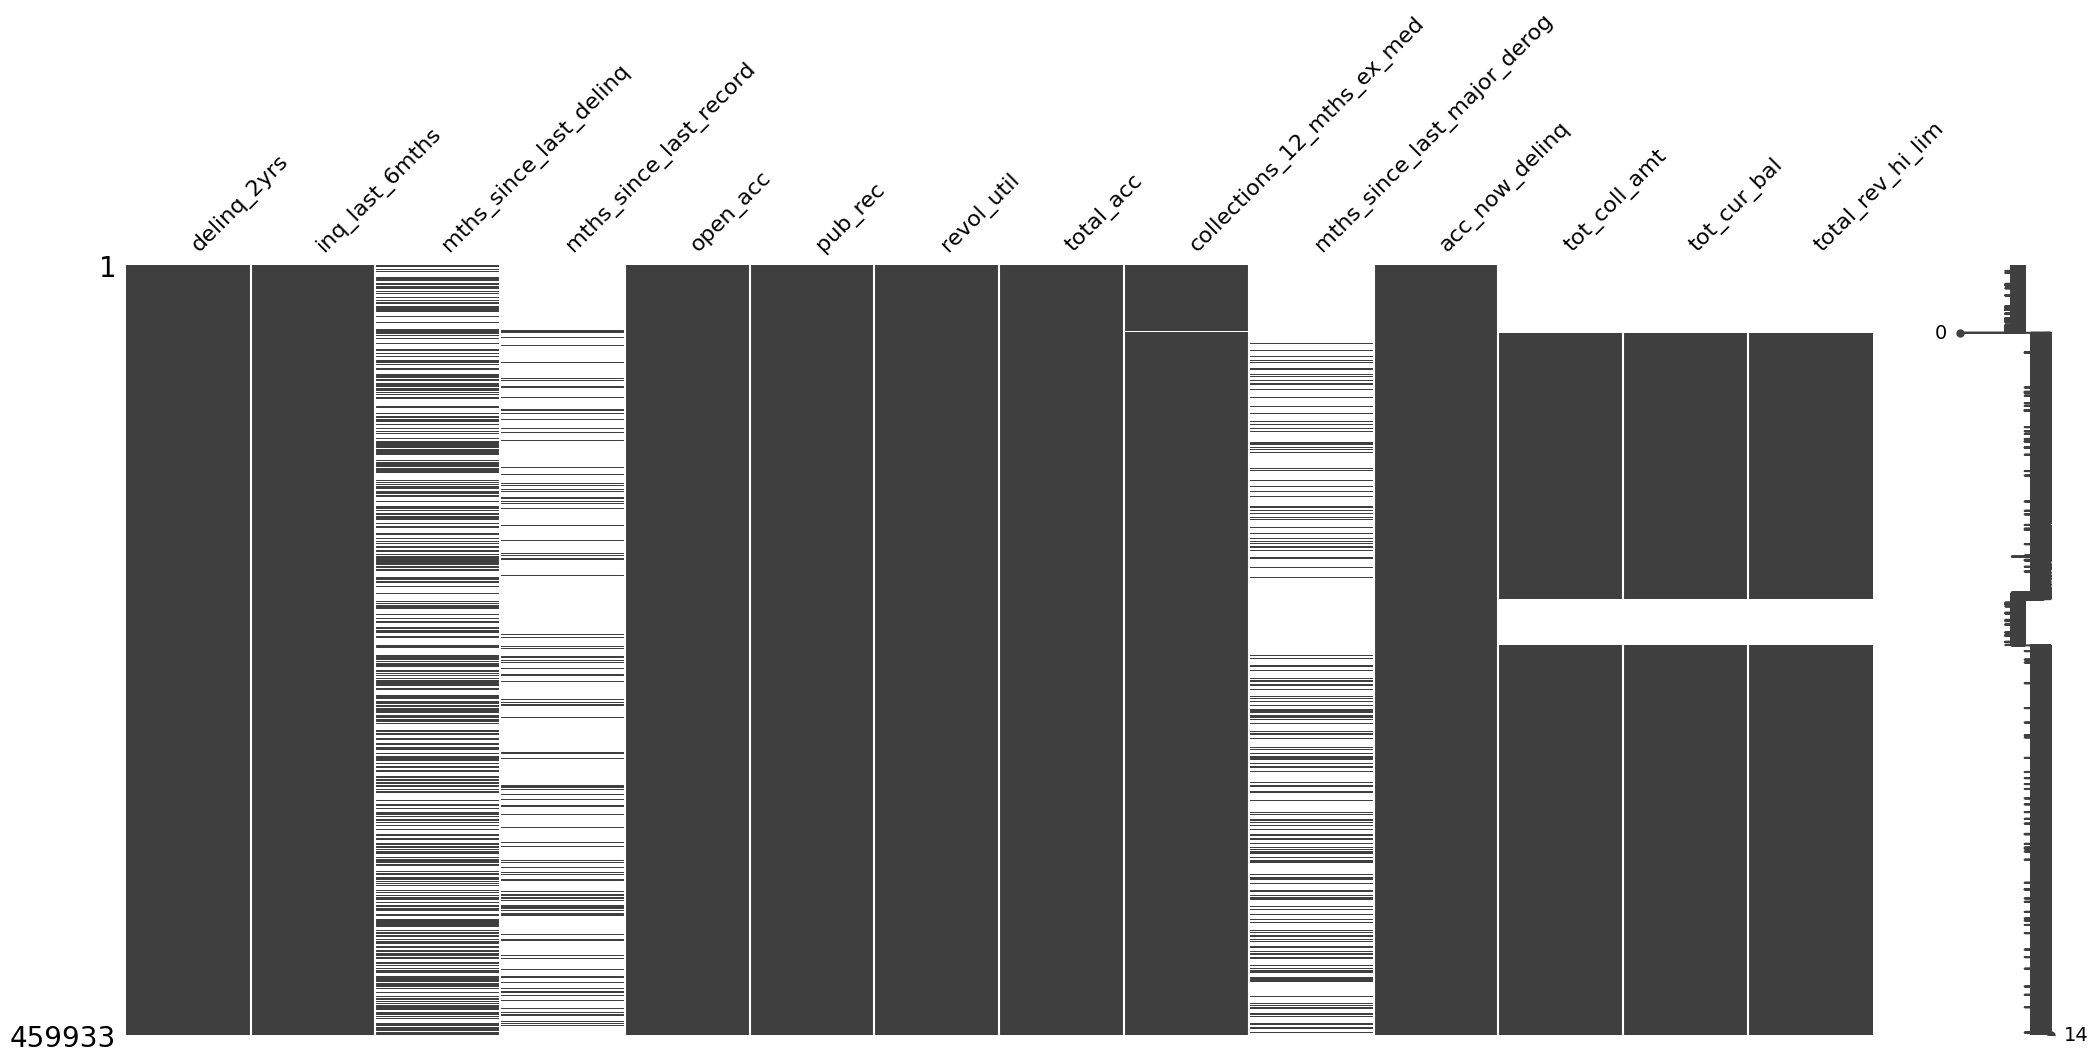

In [20]:
# visualize missing value

missingno.matrix(data[vars_num_with_na])
plt.show()

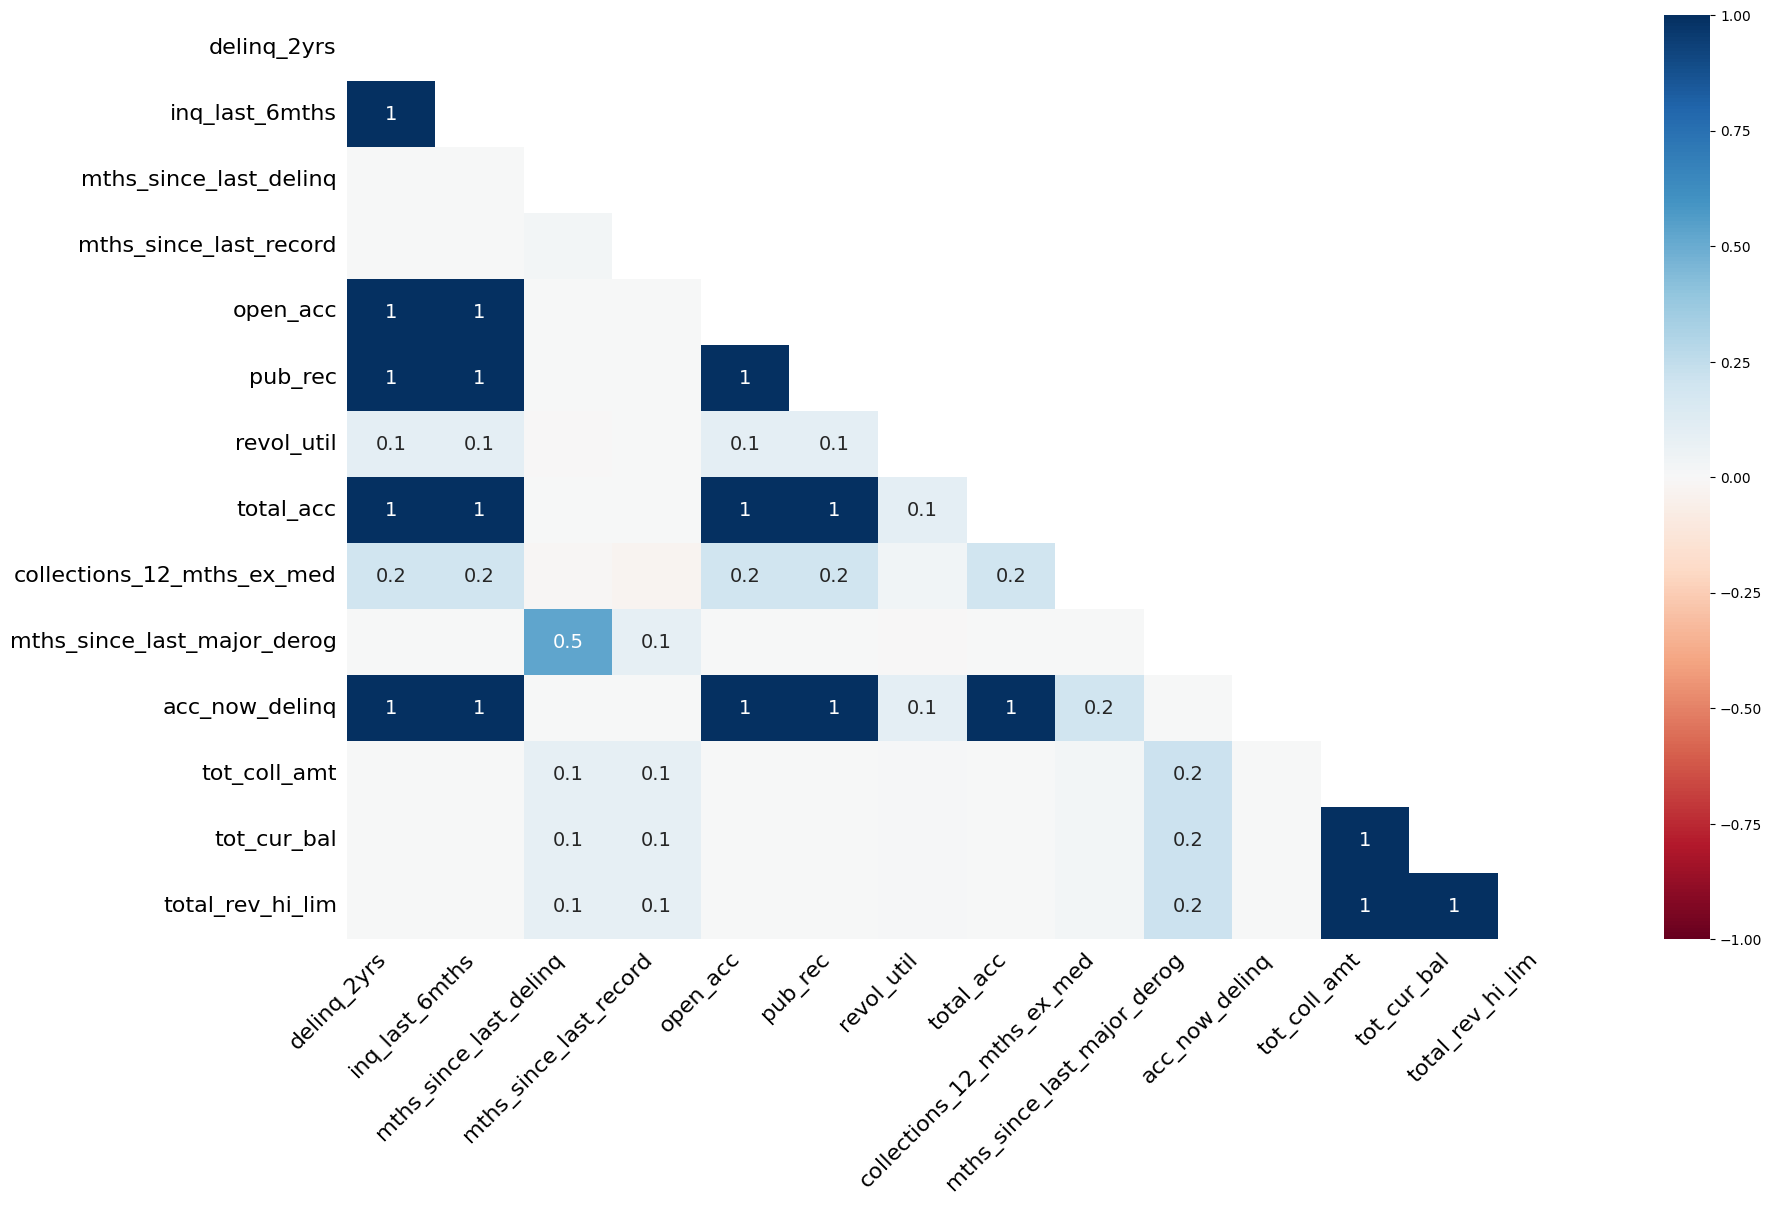

In [21]:
missingno.heatmap(data[vars_num_with_na])
plt.show()

#### Observations :

* `mths_since_last_record`, `mths_since_last_major_derog`, `mths_since_last_delinq`, has missing values more thaan 50%.
* some variables has 1 correlation missing values.

### Descriptive Statistics

In [22]:
data[vars_num].describe()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,...,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
count,459933.000000,459933.000000,459933.000000,459933.000000,459933.000000,4.599330e+05,459933.000000,459930.000000,459930.000000,212457.000000,...,459933.000000,459933.000000,459933.000000,459855.000000,97725.000000,459933.0,459930.000000,3.917380e+05,3.917380e+05,3.917380e+05
mean,14324.579015,14299.502101,14238.951367,13.809270,432.192692,7.327944e+04,17.217657,0.283519,0.790666,34.161468,...,86.522875,9.085299,3152.487771,0.009062,42.847685,1.0,0.004014,1.916277e+02,1.388860e+05,3.042577e+04
std,8281.972923,8269.582206,8285.679675,4.358972,243.303142,5.492995e+04,7.847202,0.795106,1.056547,21.759158,...,555.924548,86.073231,5581.096777,0.108517,21.662885,0.0,0.068793,1.470798e+04,1.521105e+05,3.736029e+04
min,500.000000,500.000000,0.000000,5.420000,15.690000,2.000000e+03,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
25%,8000.000000,8000.000000,8000.000000,10.990000,256.900000,4.500000e+04,11.360000,0.000000,0.000000,16.000000,...,0.000000,0.000000,312.910000,0.000000,26.000000,1.0,0.000000,0.000000e+00,2.861900e+04,1.360000e+04
50%,12000.000000,12000.000000,12000.000000,13.650000,380.170000,6.300000e+04,16.860000,0.000000,0.000000,31.000000,...,0.000000,0.000000,547.840000,0.000000,42.000000,1.0,0.000000,0.000000e+00,8.171250e+04,2.290000e+04
75%,20000.000000,20000.000000,19950.000000,16.450000,566.620000,8.900000e+04,22.780000,0.000000,1.000000,50.000000,...,0.000000,0.000000,3283.600000,0.000000,59.000000,1.0,0.000000,0.000000e+00,2.090998e+05,3.792450e+04
max,35000.000000,35000.000000,35000.000000,26.060000,1409.990000,7.500000e+06,39.990000,29.000000,33.000000,188.000000,...,33520.270000,7002.190000,36234.440000,20.000000,188.000000,1.0,5.000000,9.152545e+06,8.000078e+06,9.999999e+06


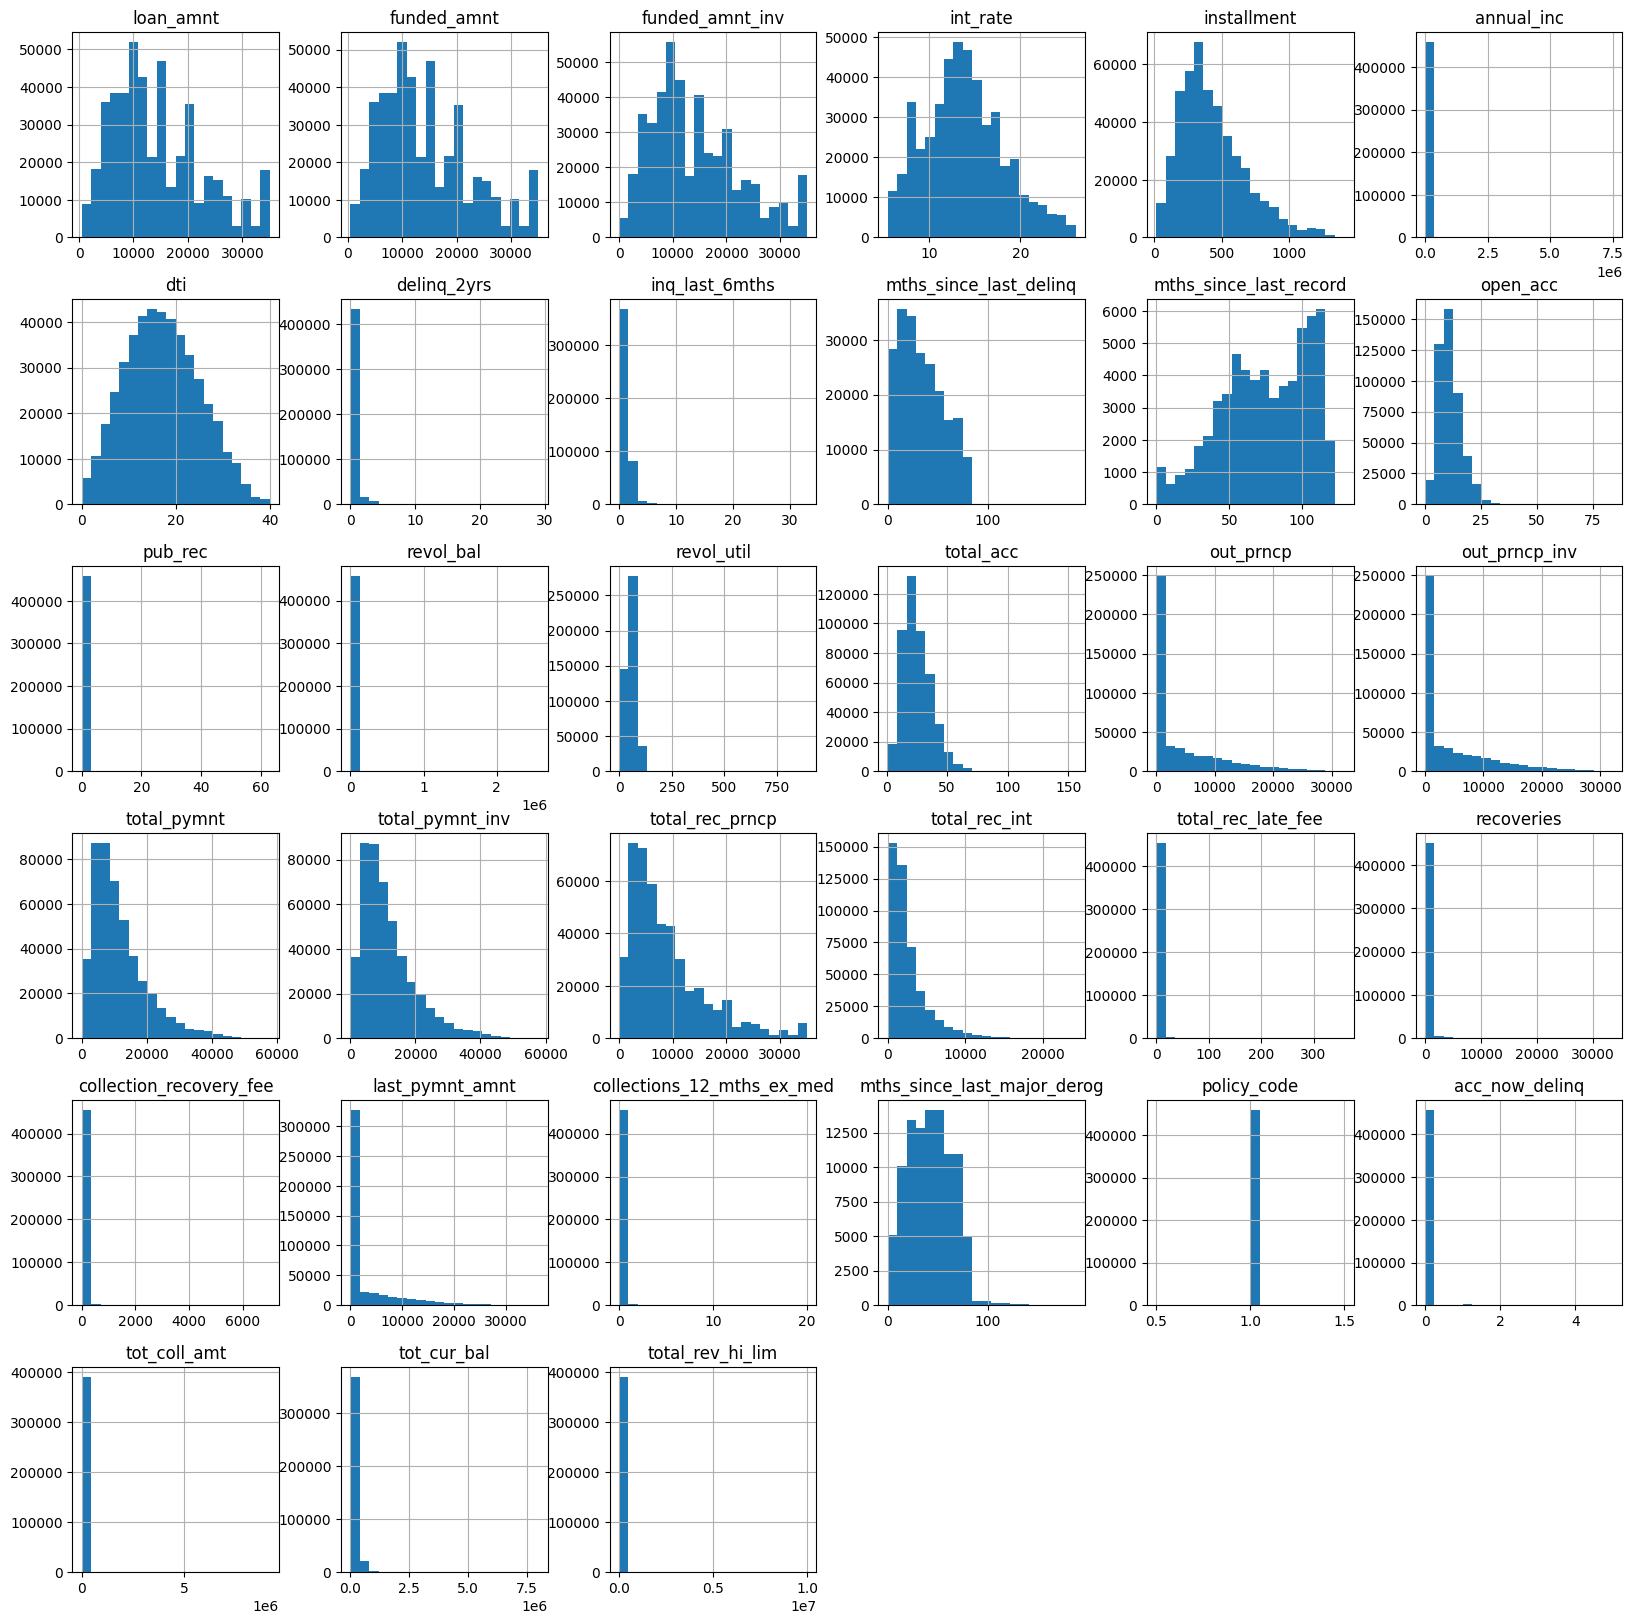

In [23]:
# histogram plot of numerical variables

data[vars_num].hist(figsize = (20, 20), bins = 20)
plt.show()

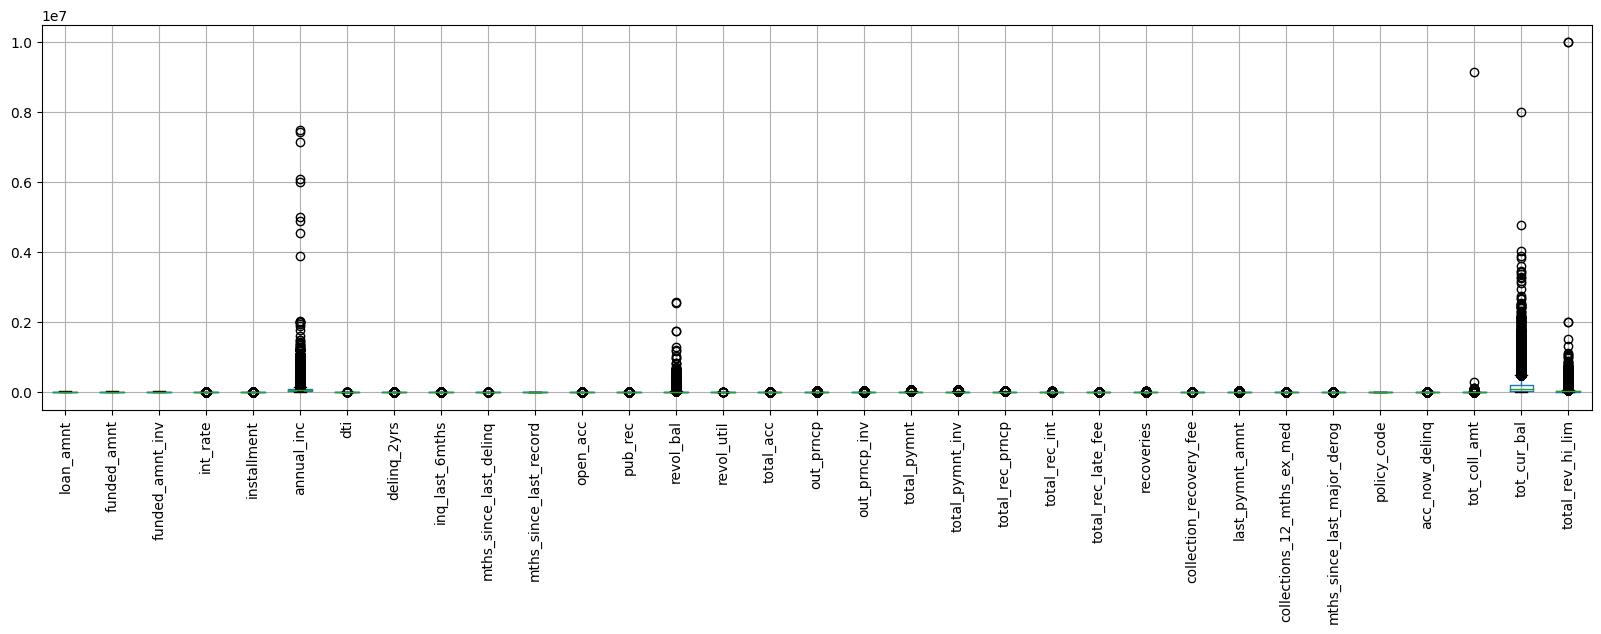

In [24]:
# bocplot of numerical variables

data[vars_num].boxplot(figsize = (20, 5))
plt.xticks(rotation = 90)
plt.show()

In [25]:
# unique values numerical variables
data[vars_num].nunique()

loan_amnt                        1350
funded_amnt                      1352
funded_amnt_inv                  9193
int_rate                          501
installment                     55054
annual_inc                      31585
dti                              3997
delinq_2yrs                        24
inq_last_6mths                     22
mths_since_last_delinq            145
mths_since_last_record            123
open_acc                           62
pub_rec                            26
revol_bal                       57748
revol_util                       1259
total_acc                         112
out_prncp                      132770
out_prncp_inv                  138223
total_pymnt                    347204
total_pymnt_inv                343318
total_rec_prncp                169952
total_rec_int                  267231
total_rec_late_fee               5502
recoveries                      22773
collection_recovery_fee         20275
last_pymnt_amnt                196776
collections_

#### Observations :

* quite lot of variables has high positive skewed.
* `policy_code` will be dropped because it contains only one unique values.

### Skewed Variables without NaN

In [26]:
# get skew data without Na
skew_vars = [col for col in vars_num if data[col].skew() >= 2 and col not in vars_num_with_na]

# see skewness each variable
data[skew_vars].skew().sort_values(ascending = False)

annual_inc                 29.906473
collection_recovery_fee    22.084851
revol_bal                  19.961807
total_rec_late_fee         14.222938
recoveries                 13.060222
last_pymnt_amnt             2.542337
total_rec_int               2.269371
dtype: float64

In [27]:
# get unique values

data[skew_vars].nunique()

annual_inc                  31585
revol_bal                   57748
total_rec_int              267231
total_rec_late_fee           5502
recoveries                  22773
collection_recovery_fee     20275
last_pymnt_amnt            196776
dtype: int64

We can see that all skewness variables is continous.

In [28]:
# define a function to check distribution and qqplot

def check_dist(df, var):
    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(df[var], bins=50)
    plt.title(f"Histogram {var}")

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[var], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[var])
    plt.title(f"Boxplot {var}")

    plt.tight_layout()
    plt.show()

In [29]:
# temporal dataframe to save data skewed transformation

df_skew = data[["loan_status"]]

**annual_inc**

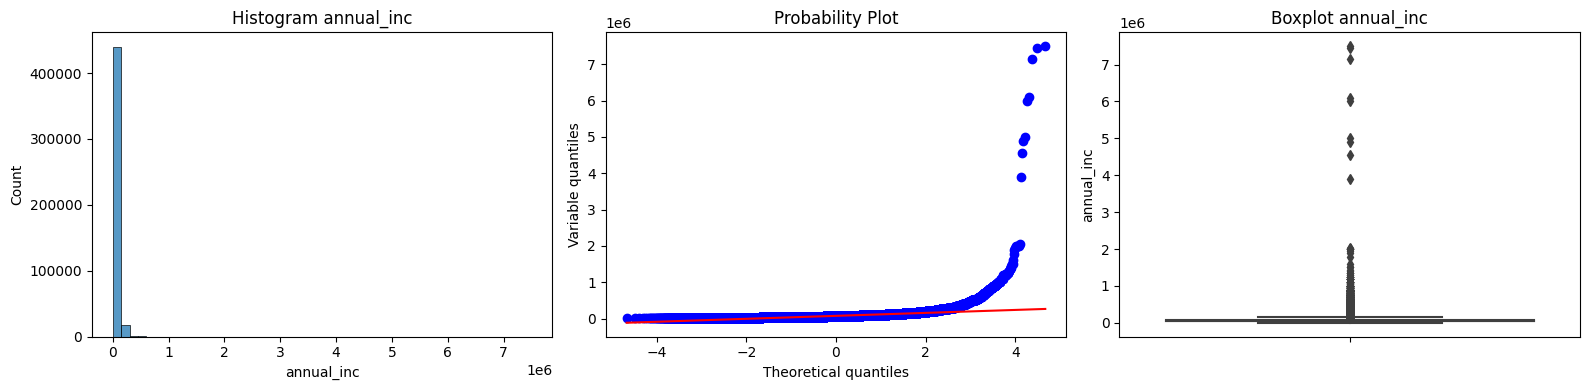

In [30]:
check_dist(data, "annual_inc")

In [31]:
# annual inc describe
display(data["annual_inc"].describe())
data["annual_inc"].var()

count    4.599330e+05
mean     7.327944e+04
std      5.492995e+04
min      2.000000e+03
25%      4.500000e+04
50%      6.300000e+04
75%      8.900000e+04
max      7.500000e+06
Name: annual_inc, dtype: float64

3017299405.657428

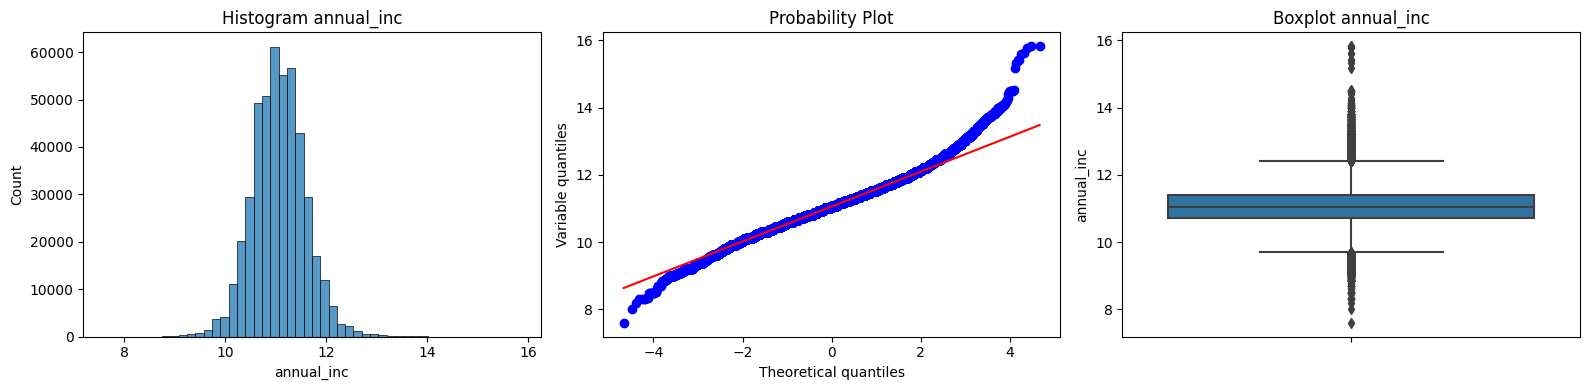

In [32]:
# apply log transformation

df_skew["annual_inc"] = data["annual_inc"].apply(np.log)
check_dist(df_skew, "annual_inc")

**revol_bal**

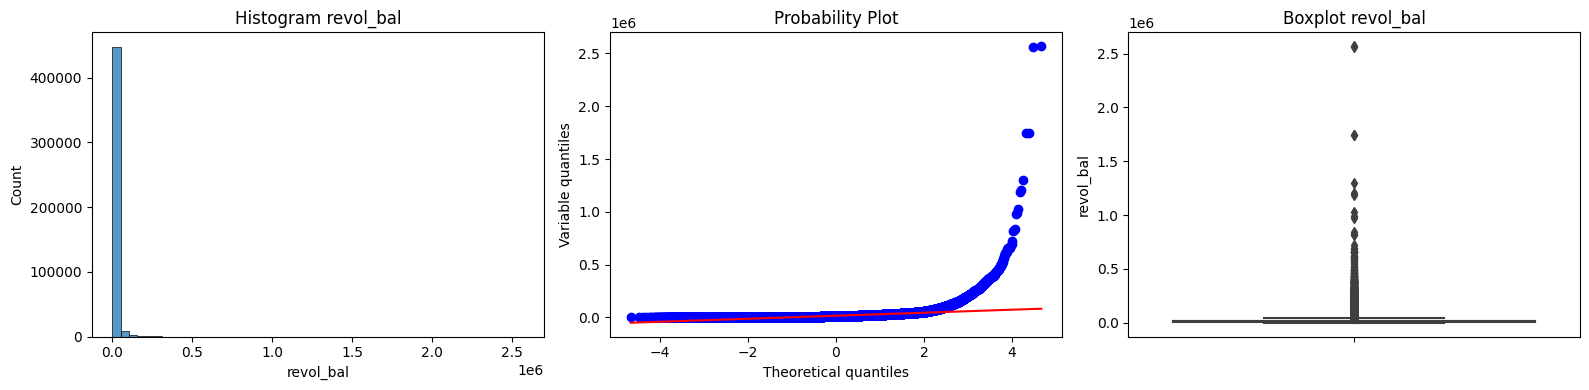

In [33]:
check_dist(data, "revol_bal")

In [34]:
# revol bal describe
display(data["revol_bal"].describe())
data["revol_bal"].var()

count    4.599330e+05
mean     1.618793e+04
std      2.040219e+04
min      0.000000e+00
25%      6.428000e+03
50%      1.177700e+04
75%      2.033200e+04
max      2.568995e+06
Name: revol_bal, dtype: float64

416249176.8081784

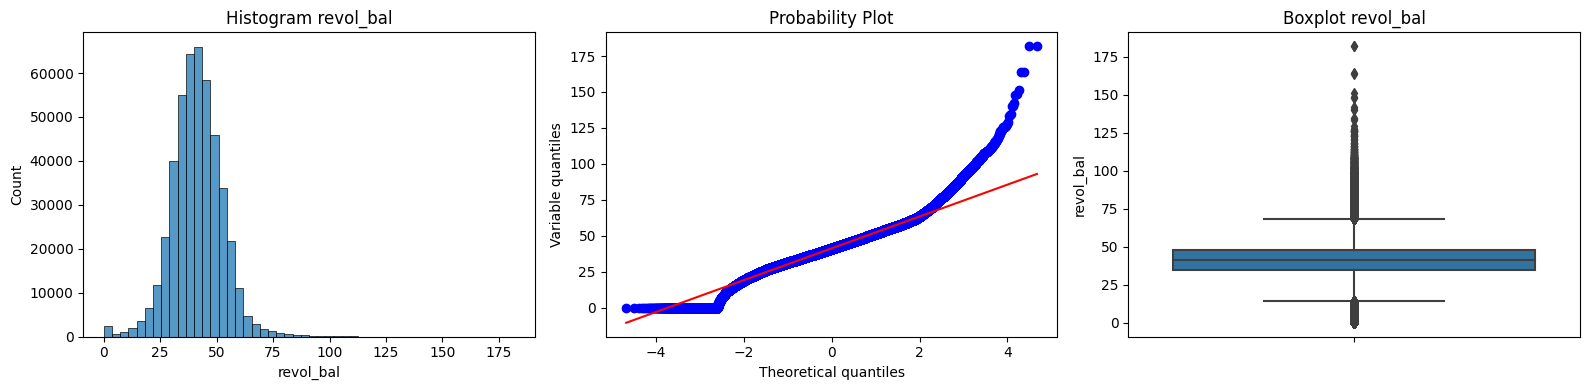

In [35]:
# apply yeo-johnson transformation
yjt = YeoJohnsonTransformer()

# fit yeo-johnson
yjt.fit(data[["revol_bal"]])

# save in temporal dataset
df_skew["revol_bal"] = yjt.transform(data[["revol_bal"]])
check_dist(df_skew, "revol_bal")

**total_rec_int**

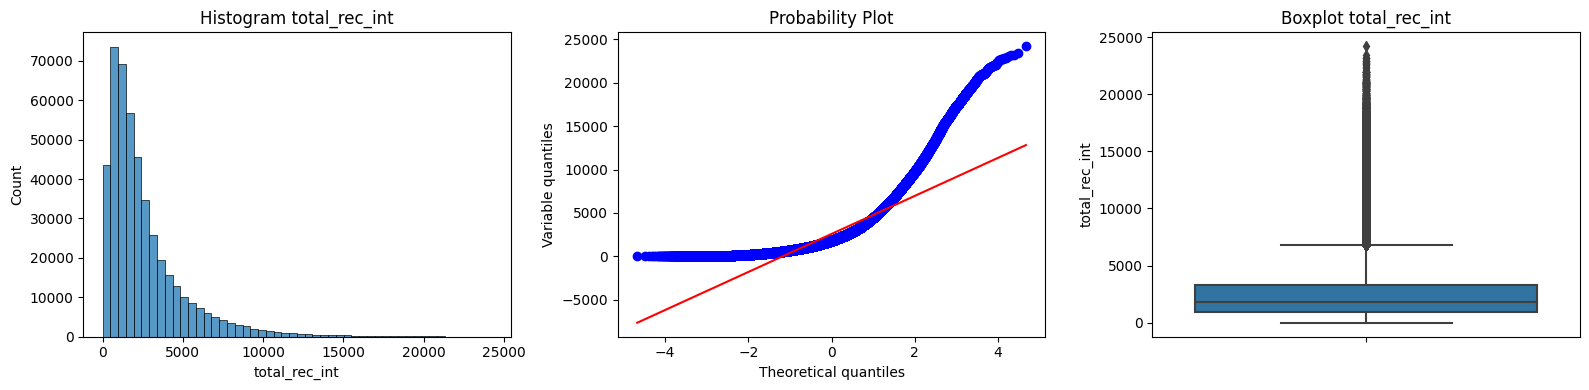

In [36]:
check_dist(data, "total_rec_int")

In [37]:
# revol bal describe
display(data["total_rec_int"].describe())
data["total_rec_int"].var()

count    459933.000000
mean       2580.453965
std        2475.290607
min           0.000000
25%         955.600000
50%        1813.470000
75%        3293.730000
max       24205.620000
Name: total_rec_int, dtype: float64

6127063.590882504

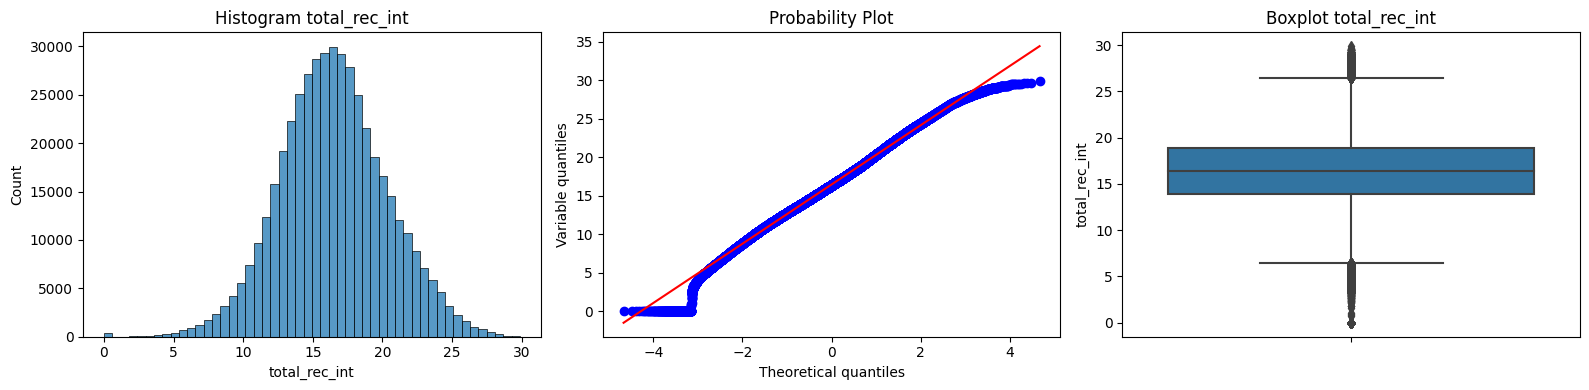

In [38]:
# apply yeo-johnson transformation
yjt = YeoJohnsonTransformer()

# fit yeo-johnson
yjt.fit(data[["total_rec_int"]])

# save in temporal dataset
df_skew["total_rec_int"] = yjt.transform(data[["total_rec_int"]])
check_dist(df_skew, "total_rec_int")

**total_rec_late_fee**

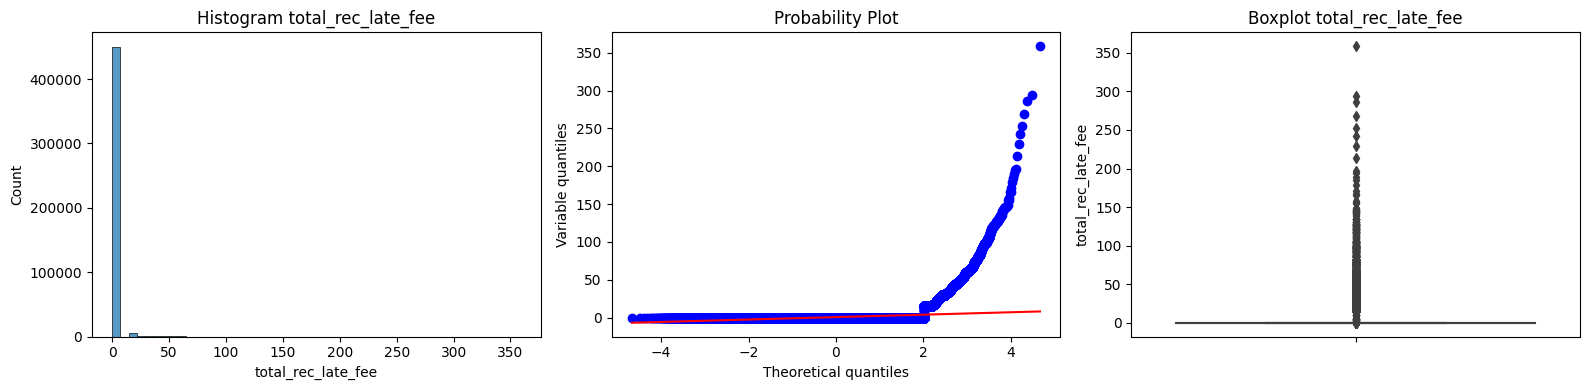

In [39]:
check_dist(data, "total_rec_late_fee")

In [40]:
# revol bal describe
display(data["total_rec_late_fee"].describe())
data["total_rec_late_fee"].var()

count    459933.000000
mean          0.610307
std           5.068696
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         358.680000
Name: total_rec_late_fee, dtype: float64

25.691684159727206

In [41]:
# check value proportion
data["total_rec_late_fee"].value_counts(normalize = True)

0.000000     0.978314
15.000000    0.004553
30.000000    0.000574
45.000000    0.000093
15.000000    0.000030
               ...   
33.085500    0.000002
44.807503    0.000002
22.933903    0.000002
14.942211    0.000002
37.430000    0.000002
Name: total_rec_late_fee, Length: 5502, dtype: float64

This variable highly dominated by zero

In [42]:
# binning

df_skew["total_rec_late_fee"] = np.where(data["total_rec_late_fee"] == 0, 0, 1)

for i in range(2):
    print(df_skew[df_skew["total_rec_late_fee"] == i]["loan_status"].value_counts(normalize = True))

good    0.897711
bad     0.102289
Name: loan_status, dtype: float64
good    0.504512
bad     0.495488
Name: loan_status, dtype: float64


**recoveries**

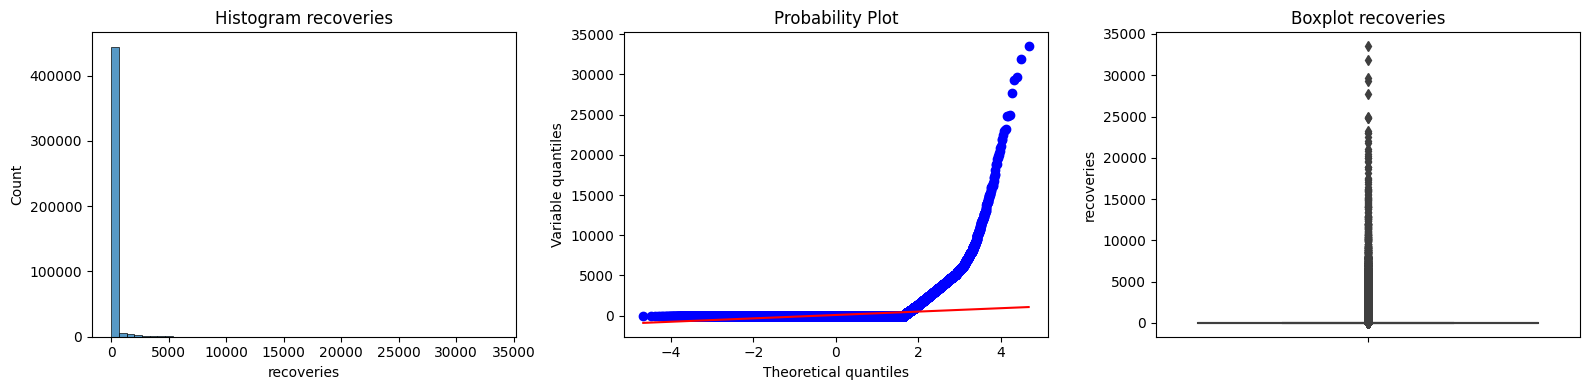

In [43]:
check_dist(data, "recoveries")

In [44]:
# annual inc describe
display(data["recoveries"].describe())
data["recoveries"].var()

count    459933.000000
mean         86.522875
std         555.924548
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       33520.270000
Name: recoveries, dtype: float64

309052.1035269578

In [45]:
data["recoveries"].value_counts(normalize = True)

0.00       0.947012
14.28      0.000020
11.70      0.000020
200.00     0.000020
10.00      0.000020
             ...   
423.23     0.000002
2311.77    0.000002
850.18     0.000002
5052.98    0.000002
1159.40    0.000002
Name: recoveries, Length: 22773, dtype: float64

In [46]:
# binning

df_skew["recoveries"] = np.where(data["recoveries"] == 0, 0, 1)

for i in range(2):
    print(df_skew[df_skew["recoveries"] == i]["loan_status"].value_counts(normalize = True))

good    0.938936
bad     0.061064
Name: loan_status, dtype: float64
bad    1.0
Name: loan_status, dtype: float64


This variables could be a good predictor when we do descretization.

**last_pymnt_amnt**

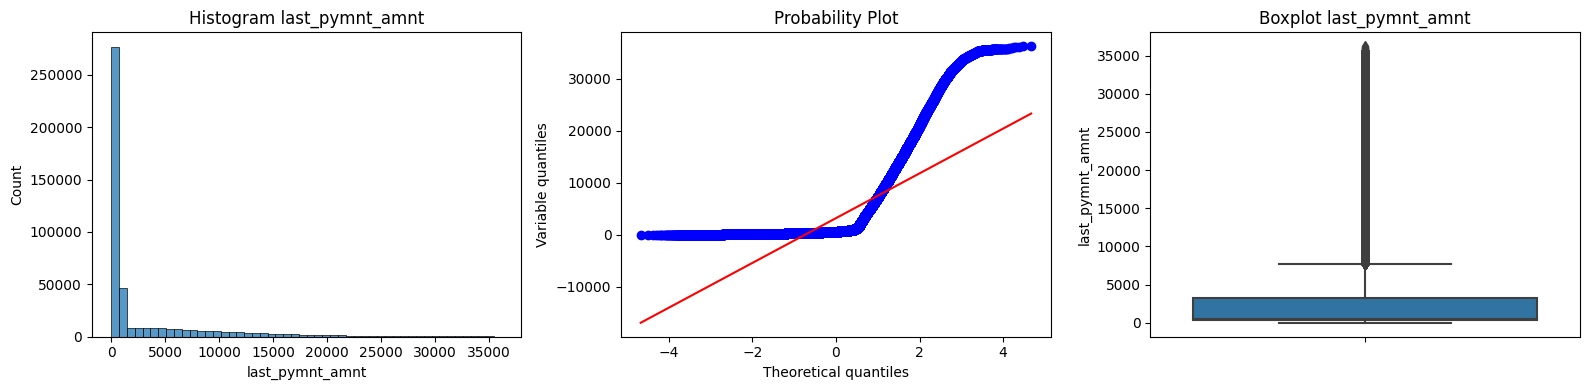

In [47]:
check_dist(data, "last_pymnt_amnt")

In [48]:
# annual inc describe
display(data["last_pymnt_amnt"].describe())
data["last_pymnt_amnt"].var()

count    459933.000000
mean       3152.487771
std        5581.096777
min           0.000000
25%         312.910000
50%         547.840000
75%        3283.600000
max       36234.440000
Name: last_pymnt_amnt, dtype: float64

31148641.22918044

**collection_recovery_fee**

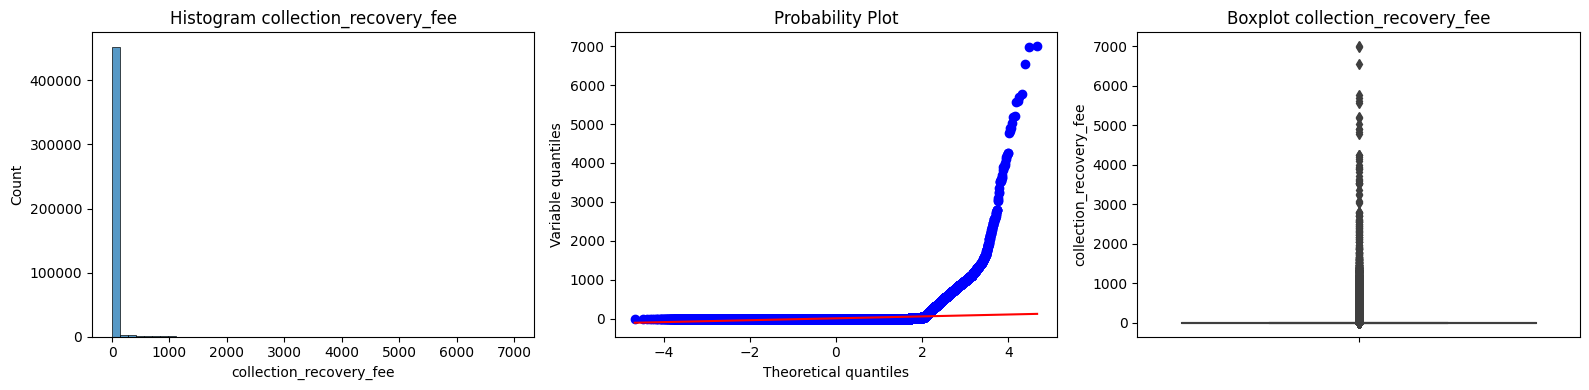

In [49]:
check_dist(data, "collection_recovery_fee")

In [50]:
data["collection_recovery_fee"].value_counts(normalize = True)

0.0000      0.949545
2.0000      0.000039
1.8000      0.000028
1.8800      0.000026
1.2000      0.000026
              ...   
330.4404    0.000002
149.1210    0.000002
2.9795      0.000002
8.8326      0.000002
11.5940     0.000002
Name: collection_recovery_fee, Length: 20275, dtype: float64

In [51]:
# binning

df_skew["collection_recovery_fee"] = np.where(data["collection_recovery_fee"] == 0, 0, 1)

for i in range(2):
    print(df_skew[df_skew["collection_recovery_fee"] == i]["loan_status"].value_counts(normalize = True))

good    0.936432
bad     0.063568
Name: loan_status, dtype: float64
bad    1.0
Name: loan_status, dtype: float64


### Skewed variables with NaN

In [52]:
# get skew data without Na
skew_vars = [col for col in vars_num if data[col].skew() >= 2 and col in vars_num_with_na]

# see skewness each variable
data[skew_vars].skew().sort_values(ascending = False)

tot_coll_amt                  615.150533
total_rev_hi_lim              100.745626
collections_12_mths_ex_med     31.497688
acc_now_delinq                 20.808769
pub_rec                        15.059597
delinq_2yrs                     5.359999
tot_cur_bal                     3.028369
dtype: float64

In [53]:
data[skew_vars].nunique()

delinq_2yrs                       24
pub_rec                           26
collections_12_mths_ex_med         9
acc_now_delinq                     6
tot_coll_amt                    6275
tot_cur_bal                   219289
total_rev_hi_lim               14528
dtype: int64

**tot_coll_amt**

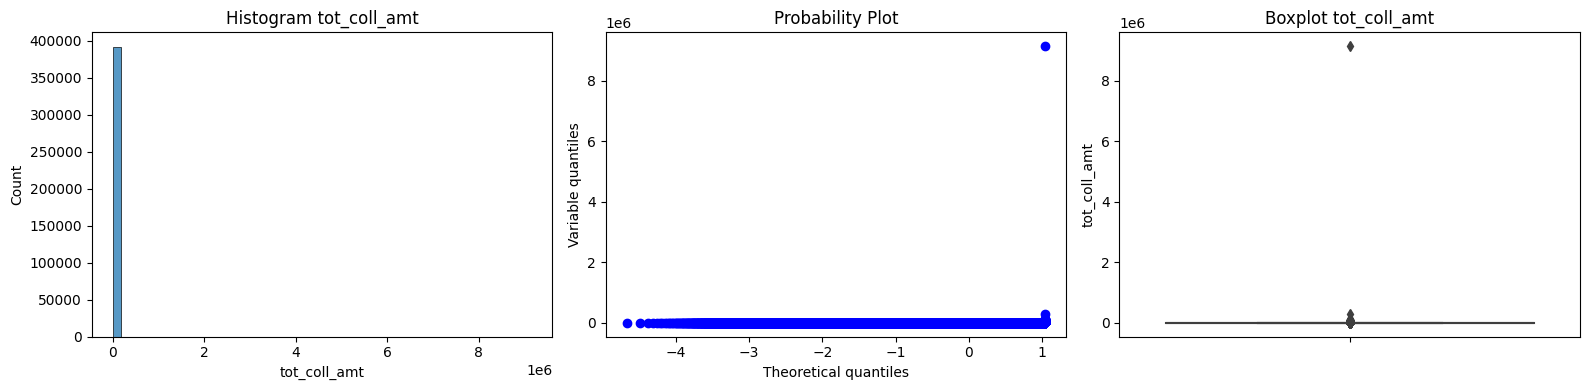

In [54]:
check_dist(data, "tot_coll_amt")

In [55]:
data["tot_coll_amt"].describe()

count    3.917380e+05
mean     1.916277e+02
std      1.470798e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      9.152545e+06
Name: tot_coll_amt, dtype: float64

In [56]:
data["tot_coll_amt"].value_counts(normalize = True)

0.0        0.874633
50.0       0.002114
100.0      0.001634
75.0       0.001299
200.0      0.000781
             ...   
22819.0    0.000003
9229.0     0.000003
4867.0     0.000003
8826.0     0.000003
6532.0     0.000003
Name: tot_coll_amt, Length: 6275, dtype: float64

**total_rev_hi_lim**

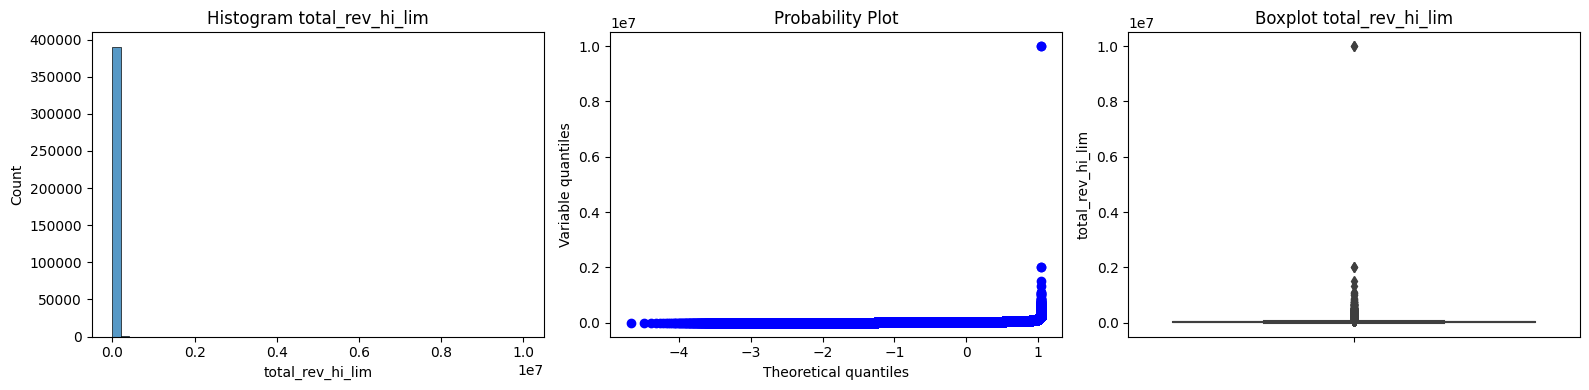

In [57]:
check_dist(data, "total_rev_hi_lim")

In [58]:
data["total_rev_hi_lim"].describe()

count    3.917380e+05
mean     3.042577e+04
std      3.736029e+04
min      0.000000e+00
25%      1.360000e+04
50%      2.290000e+04
75%      3.792450e+04
max      9.999999e+06
Name: total_rev_hi_lim, dtype: float64

In [59]:
data["total_rev_hi_lim"].value_counts(normalize = True)

15000.0     0.003520
13500.0     0.003342
10000.0     0.003290
12000.0     0.003275
14500.0     0.003265
              ...   
48354.0     0.000003
90040.0     0.000003
16218.0     0.000003
31881.0     0.000003
479500.0    0.000003
Name: total_rev_hi_lim, Length: 14528, dtype: float64

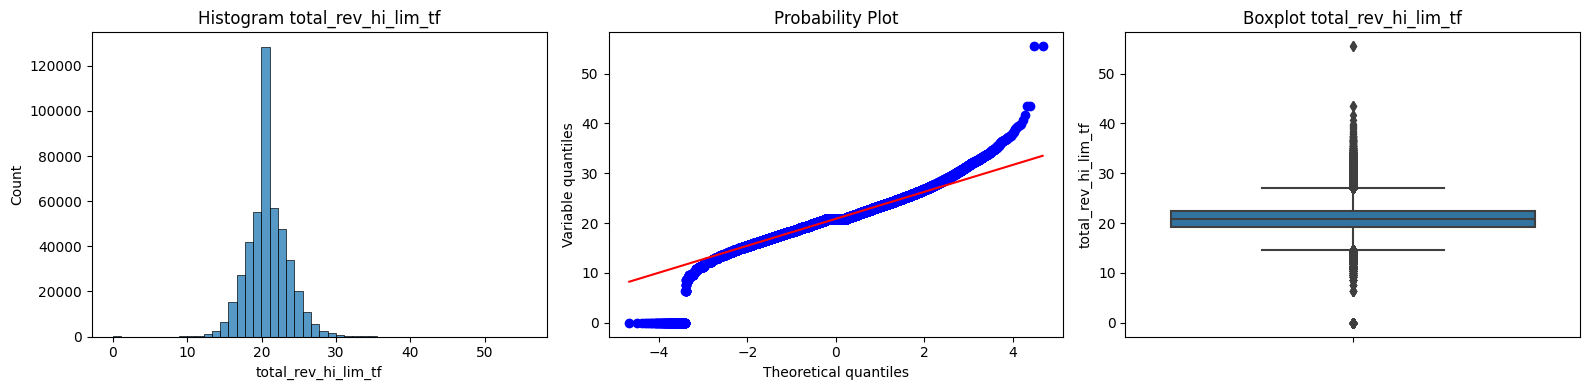

In [60]:
# fill missing value
df_skew["total_rev_hi_lim"] = data["total_rev_hi_lim"].fillna(data["total_rev_hi_lim"].median())

# apply yeo-johnson transformation
yjt = YeoJohnsonTransformer()

# fit yeo-johnson
yjt.fit(df_skew[["total_rev_hi_lim"]])

# save in temporal dataset
df_skew["total_rev_hi_lim_tf"] = yjt.transform(df_skew[["total_rev_hi_lim"]])
check_dist(df_skew, "total_rev_hi_lim_tf")

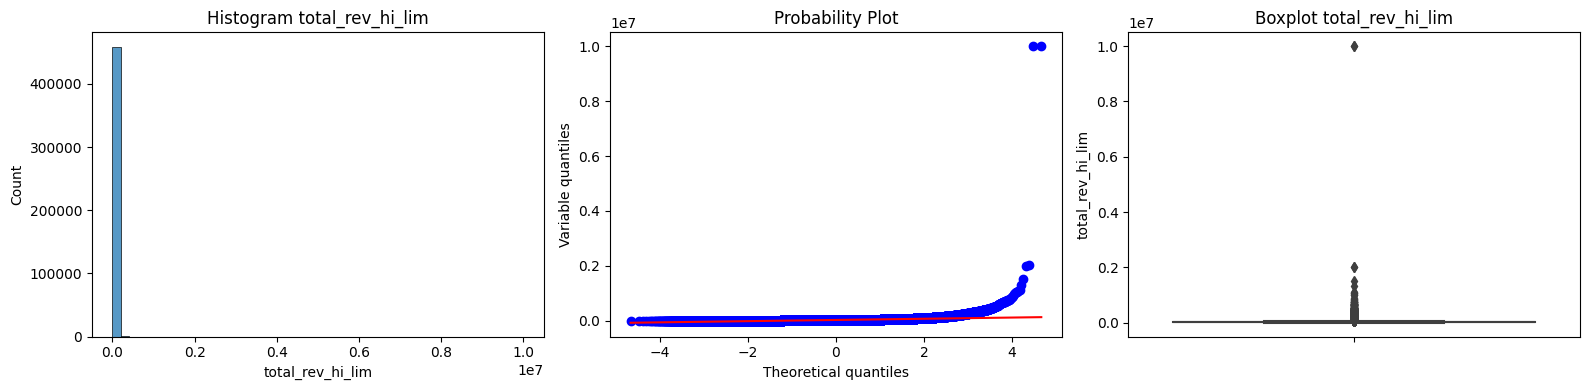

In [61]:
check_dist(df_skew, "total_rev_hi_lim")

**collections_12_mths_ex_med**

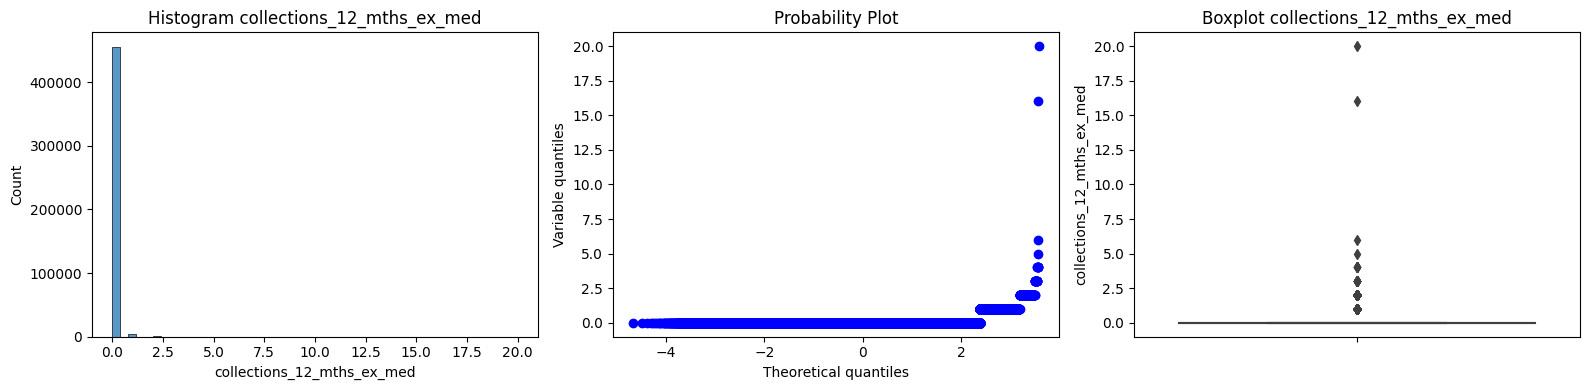

In [62]:
check_dist(data, "collections_12_mths_ex_med")

In [63]:
data["collections_12_mths_ex_med"].describe()

count    459855.000000
mean          0.009062
std           0.108517
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          20.000000
Name: collections_12_mths_ex_med, dtype: float64

In [64]:
data["collections_12_mths_ex_med"].value_counts(normalize = True)

0.0     0.991623
1.0     0.007842
2.0     0.000474
3.0     0.000039
4.0     0.000013
6.0     0.000002
16.0    0.000002
20.0    0.000002
5.0     0.000002
Name: collections_12_mths_ex_med, dtype: float64

**acc_now_delinq**

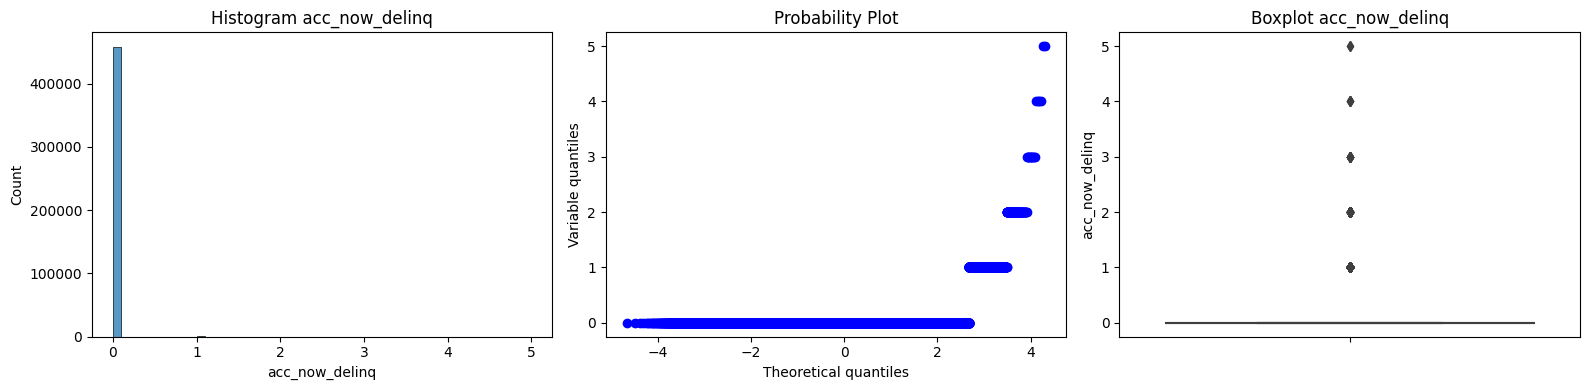

In [65]:
check_dist(data, "acc_now_delinq")

In [66]:
data["acc_now_delinq"].value_counts(normalize = True)

0.0    0.996278
1.0    0.003485
2.0    0.000200
3.0    0.000024
4.0    0.000009
5.0    0.000004
Name: acc_now_delinq, dtype: float64

**pub_rec**

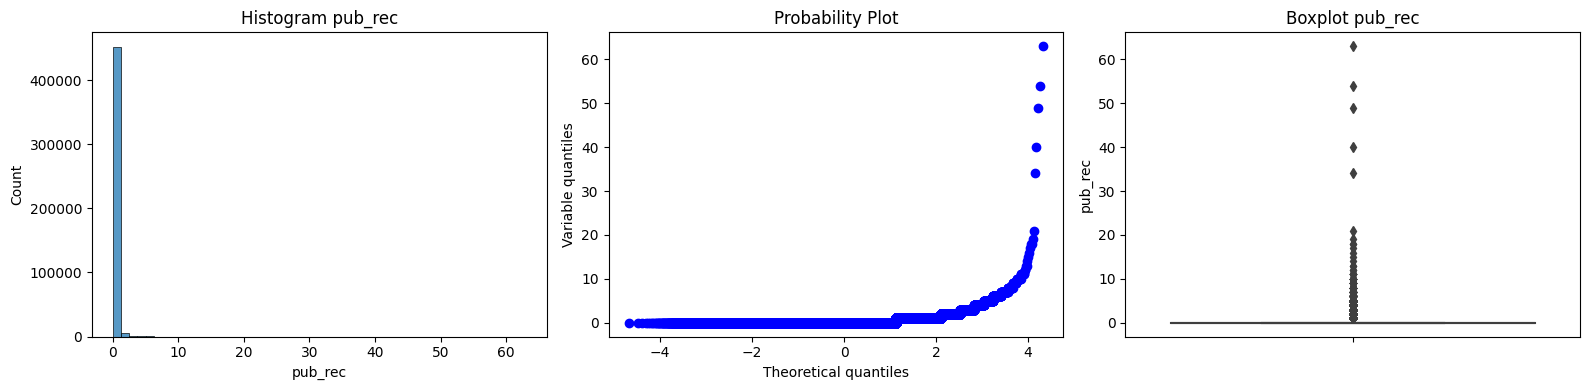

In [67]:
check_dist(data, "pub_rec")

In [68]:
data["pub_rec"].value_counts(normalize = True)

0.0     0.868360
1.0     0.113861
2.0     0.012008
3.0     0.003466
4.0     0.001109
5.0     0.000594
6.0     0.000287
7.0     0.000135
8.0     0.000063
9.0     0.000035
10.0    0.000028
11.0    0.000017
12.0    0.000004
18.0    0.000004
13.0    0.000004
40.0    0.000002
34.0    0.000002
21.0    0.000002
63.0    0.000002
54.0    0.000002
14.0    0.000002
15.0    0.000002
16.0    0.000002
19.0    0.000002
49.0    0.000002
17.0    0.000002
Name: pub_rec, dtype: float64

**delinq_2yrs**

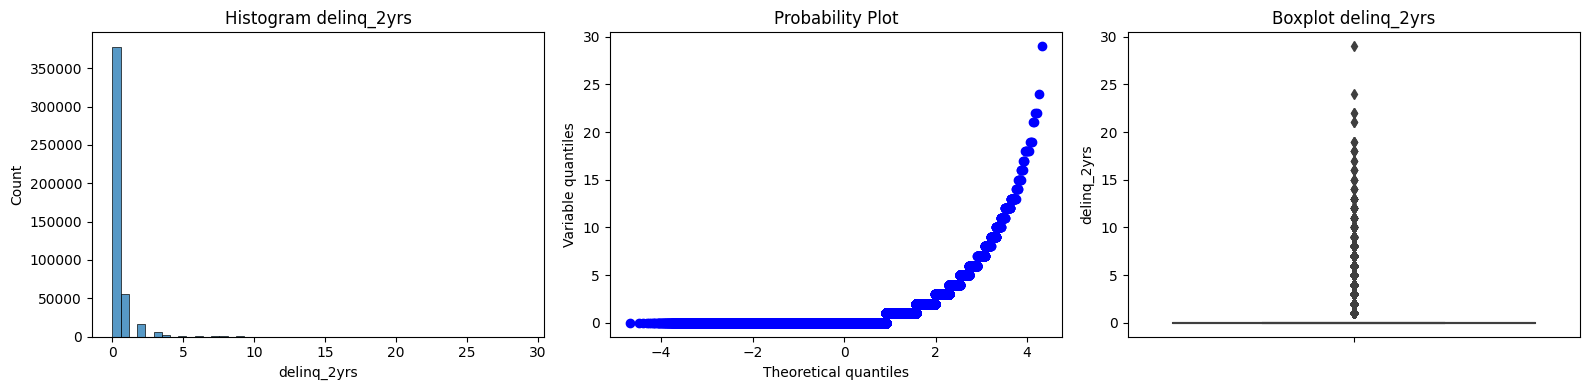

In [69]:
check_dist(data, "delinq_2yrs")

In [70]:
data["delinq_2yrs"].value_counts(normalize = True)

0.0     0.821823
1.0     0.120405
2.0     0.034834
3.0     0.012117
4.0     0.005068
5.0     0.002635
6.0     0.001339
7.0     0.000728
8.0     0.000372
9.0     0.000237
10.0    0.000139
11.0    0.000087
12.0    0.000083
13.0    0.000052
15.0    0.000015
14.0    0.000015
18.0    0.000013
16.0    0.000011
17.0    0.000007
19.0    0.000007
21.0    0.000004
22.0    0.000004
29.0    0.000002
24.0    0.000002
Name: delinq_2yrs, dtype: float64

**tot_cur_bal**

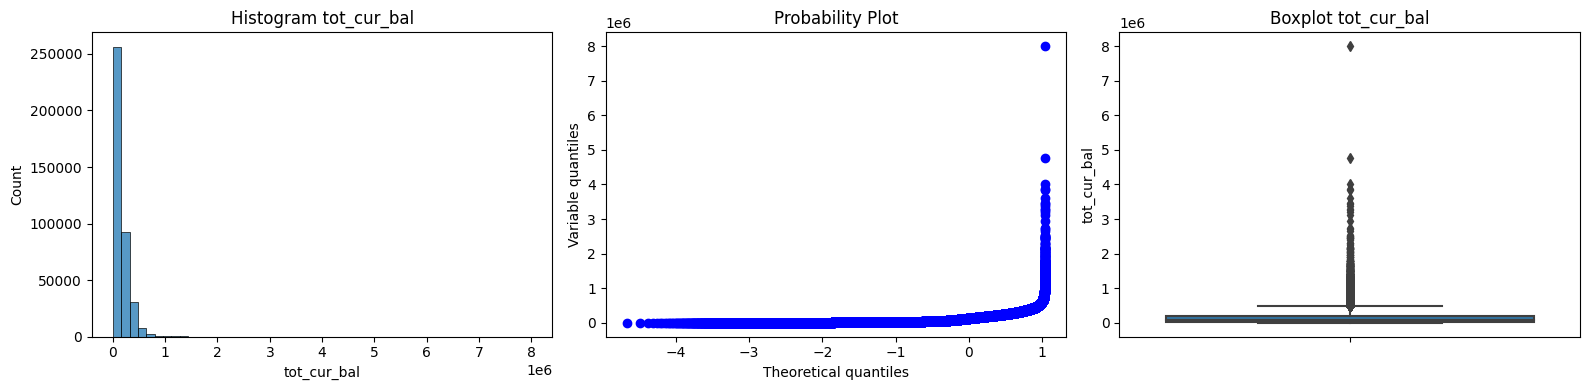

In [71]:
check_dist(data, "tot_cur_bal")

In [72]:
data["tot_cur_bal"].describe()

count    3.917380e+05
mean     1.388860e+05
std      1.521105e+05
min      0.000000e+00
25%      2.861900e+04
50%      8.171250e+04
75%      2.090998e+05
max      8.000078e+06
Name: tot_cur_bal, dtype: float64

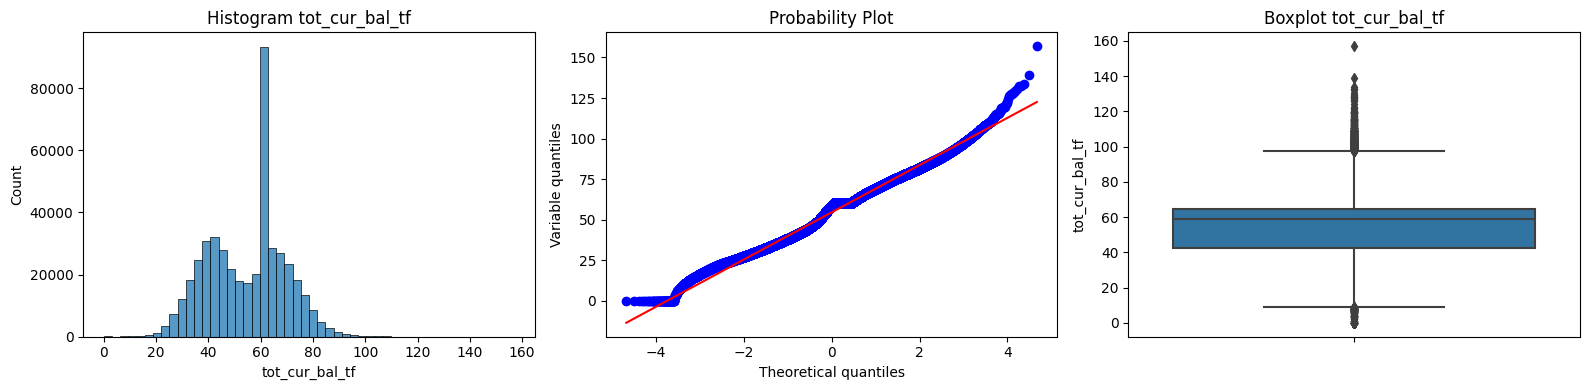

In [73]:
# fill missing value
df_skew["tot_cur_bal"] = data["tot_cur_bal"].fillna(data["tot_cur_bal"].median())

# apply yeo-johnson transformation
yjt = YeoJohnsonTransformer()

# fit yeo-johnson
yjt.fit(df_skew[["tot_cur_bal"]])

# save in temporal dataset
df_skew["tot_cur_bal_tf"] = yjt.transform(df_skew[["tot_cur_bal"]])
check_dist(df_skew, "tot_cur_bal_tf")

#### Observations :

* `tot_cur_bal` adn `total_rev_hi_lim` will be impute by median, and transform with **yeo-johnson**
* `delinq_2yrs`, `pub_rec`, `tot_coll_amt` will be discretize.
* `acc_now_delinq` and `collections_12_mths_ex_med` will be removed because highly dominated by one value.

### Non Skewed variables with NaN

In [74]:
# get skew data without Na
non_skew_vars = [col for col in vars_num if data[col].skew() < 2 and col in vars_num_with_na]

# see skewness each variable
data[non_skew_vars].skew().sort_values(ascending = False)

inq_last_6mths                 1.829688
open_acc                       1.165264
total_acc                      0.814337
mths_since_last_delinq         0.464289
mths_since_last_major_derog    0.269660
revol_util                    -0.162977
mths_since_last_record        -0.423373
dtype: float64

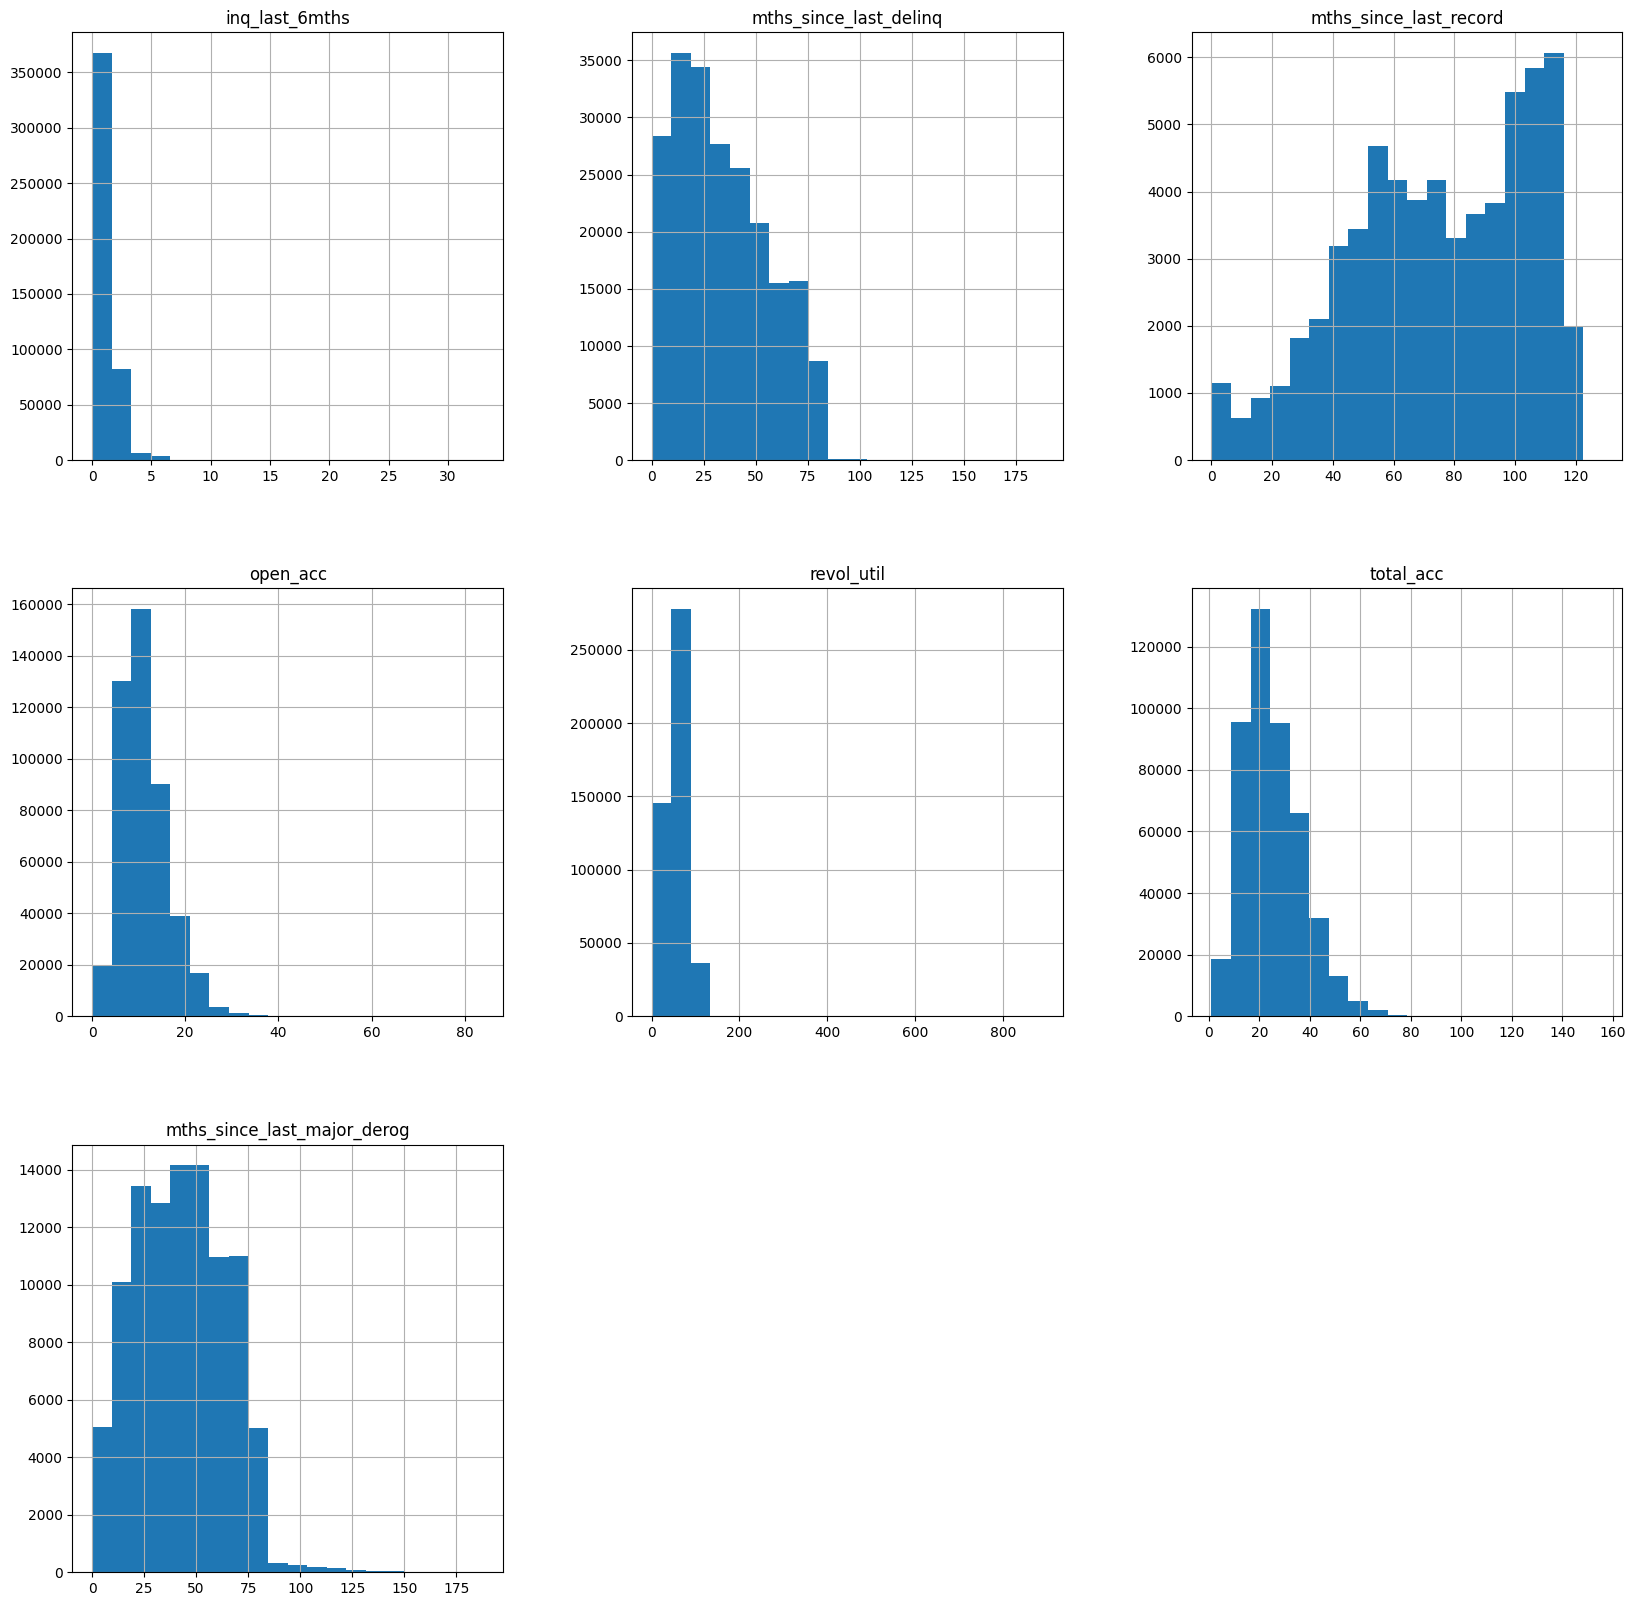

In [75]:
# histogram plot

data[non_skew_vars].hist(figsize = (20, 20), bins = 20)
plt.show()

In [76]:
df_temp = data[non_skew_vars]

for var in non_skew_vars:
    df_temp[var].fillna(df_temp[var].mean(), inplace = True)

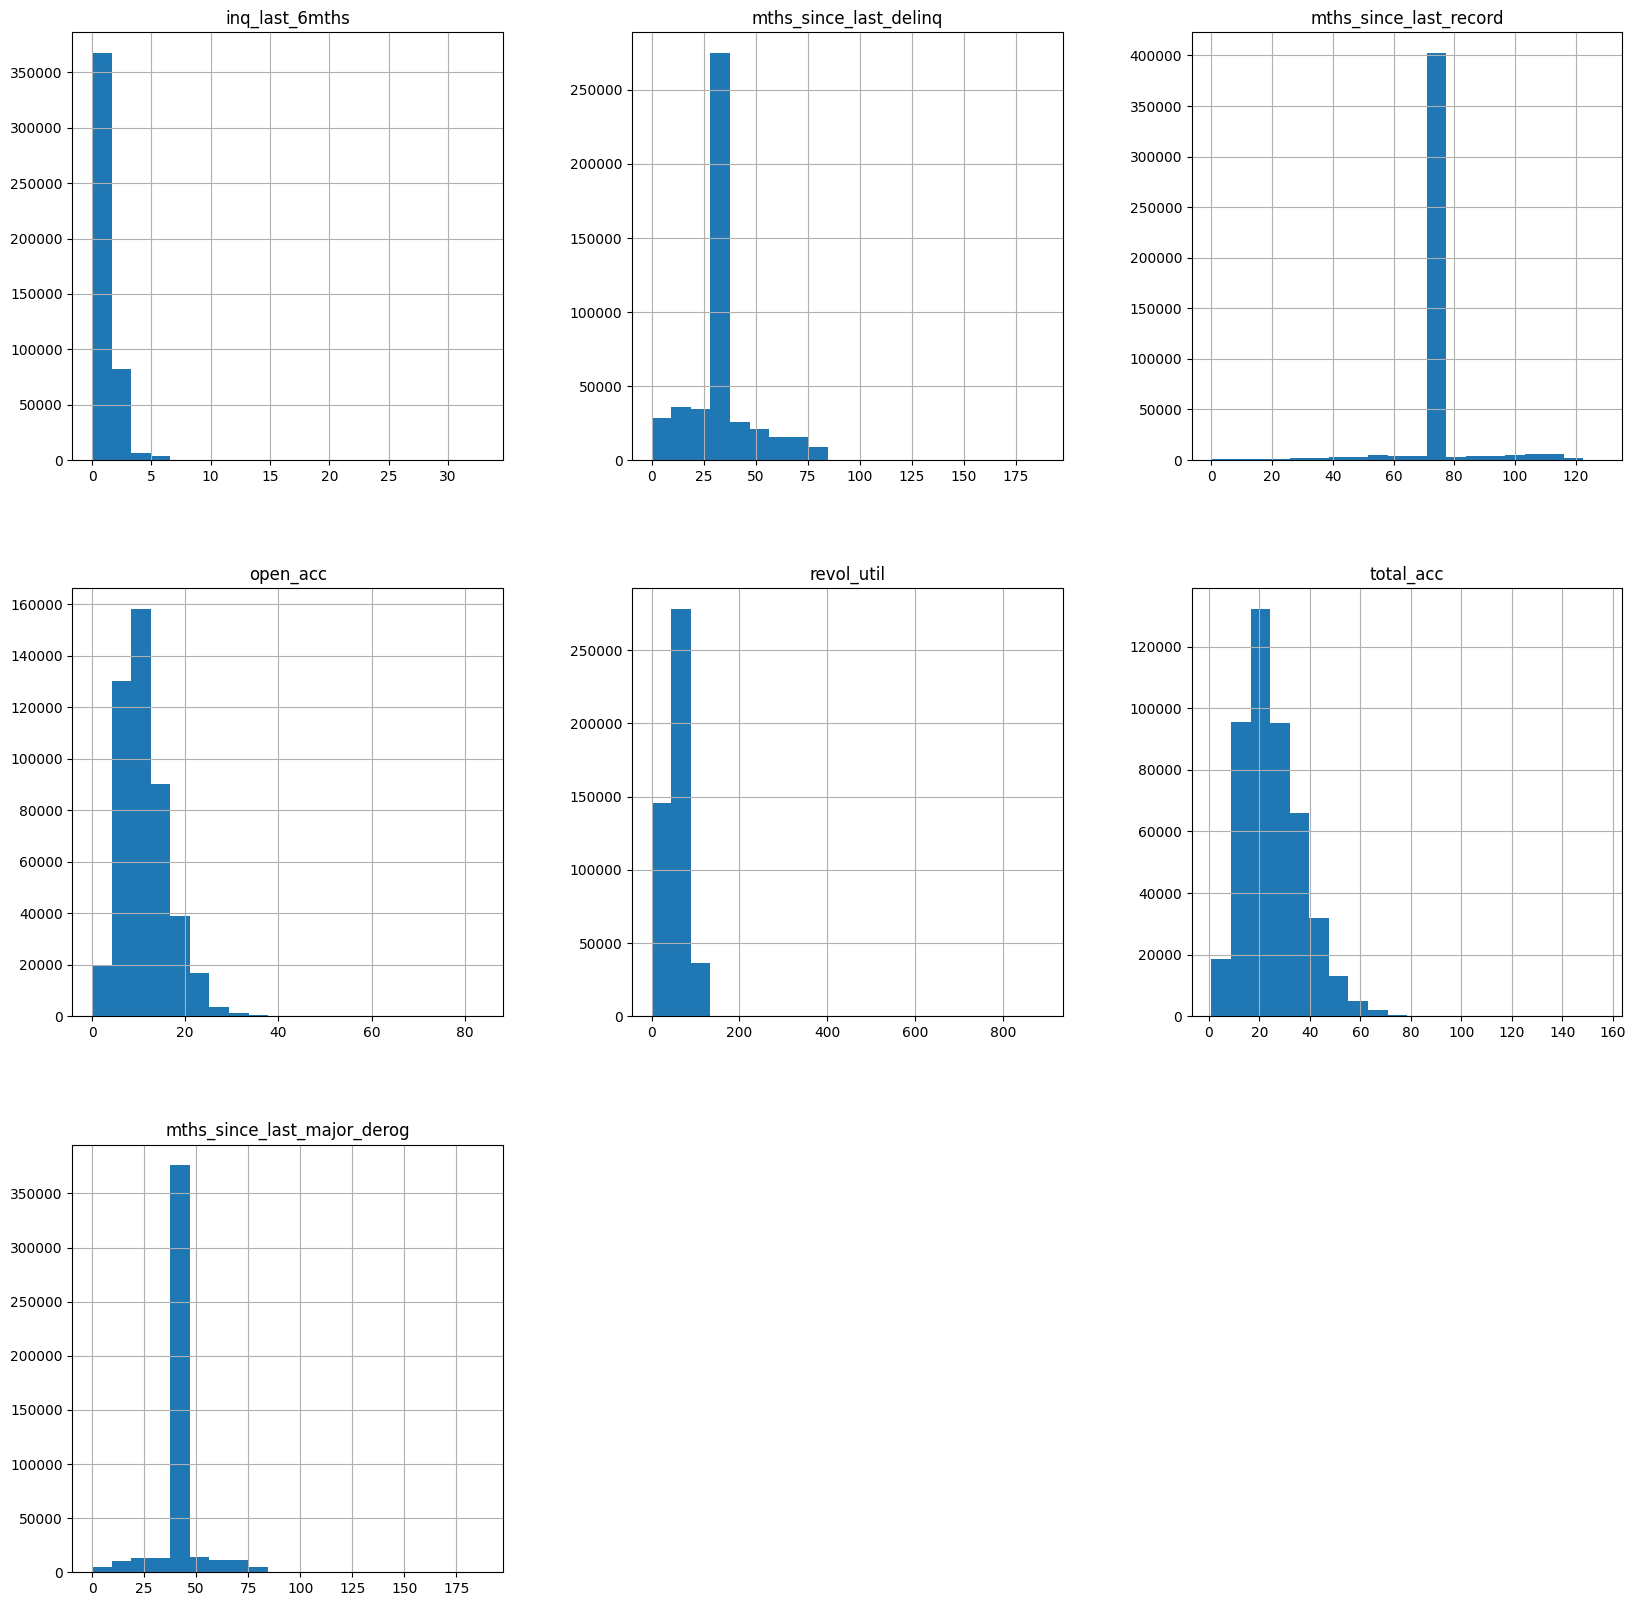

In [77]:
# histogram plot of numerical variables

df_temp[non_skew_vars].hist(figsize = (20, 20), bins = 20)
plt.show()

## Categorical Variables

In [78]:
print(len(vars_cat))
vars_cat

21


['term',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'earliest_cr_line',
 'initial_list_status',
 'last_pymnt_d',
 'next_pymnt_d',
 'last_credit_pull_d',
 'application_type']

### Missing Values

In [79]:
vars_cat_with_na = [col for col in vars_cat if data[col].isna().sum() > 0]
print(f"Numbers of categorical variables with Na : {len(vars_cat_with_na)}")

Numbers of categorical variables with Na : 8


In [80]:
# percentage

data[vars_cat_with_na].isna().mean().sort_values(ascending = False)

desc                  0.731380
next_pymnt_d          0.494015
emp_title             0.059265
emp_length            0.045263
last_pymnt_d          0.000818
last_credit_pull_d    0.000087
title                 0.000041
earliest_cr_line      0.000007
dtype: float64

### Cardinality and Rare Label

In [81]:
# check cardinality cat vars

data[vars_cat].nunique().sort_values()

application_type            1
initial_list_status         2
pymnt_plan                  2
loan_status                 2
term                        2
verification_status         3
home_ownership              6
grade                       7
emp_length                 11
purpose                    14
sub_grade                  35
addr_state                 50
next_pymnt_d               72
issue_d                    91
last_pymnt_d               98
last_credit_pull_d        102
earliest_cr_line          664
zip_code                  884
title                   61769
desc                   122039
emp_title              203002
dtype: int64

`application_type` has constant value, we dont need this variable.

variable `desc` is a free text, we assume that variables `title` and `emp_title` is alse free text because they have high cardinality. we can not make these variables as observation because their value has infinite posibility.

`grade` and `sub_grade` is derivated from `grade`, then we only use `grade`.

In [82]:
# function to detect rare

def detect_rare(df, var):
    plt.title(f"Cardinality of {var}")
    ax = df[var].value_counts(normalize = True).plot(kind = "bar")
    ax.axhline(y = 0.01, color = "red")
    plt.show()

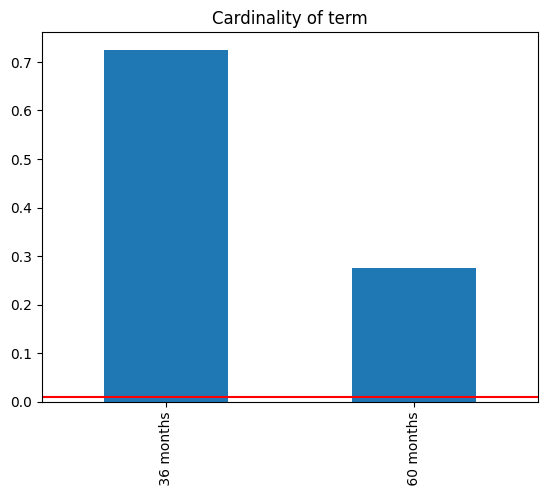

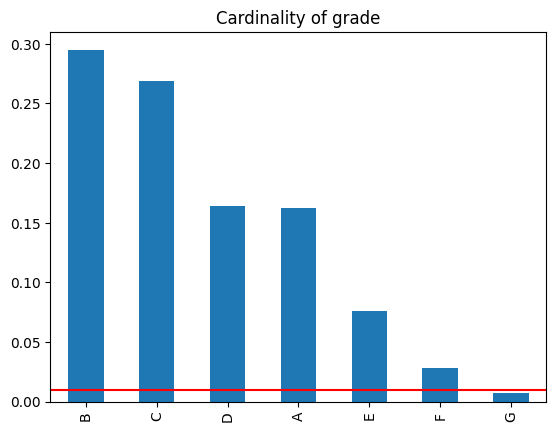

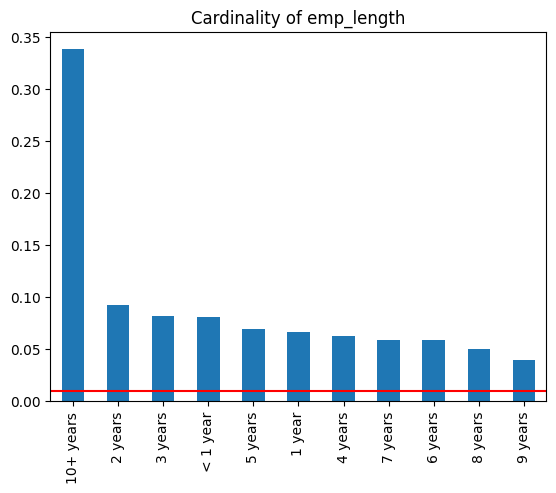

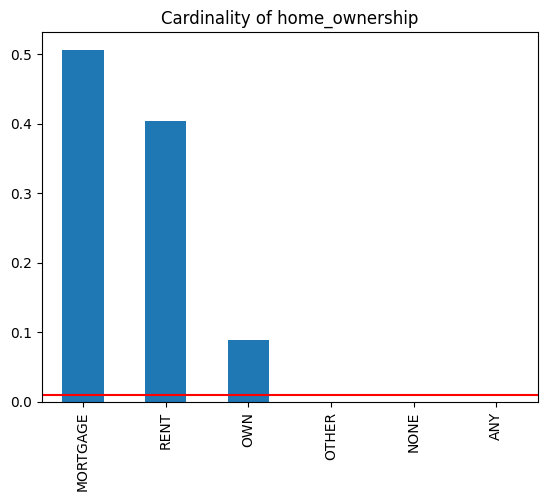

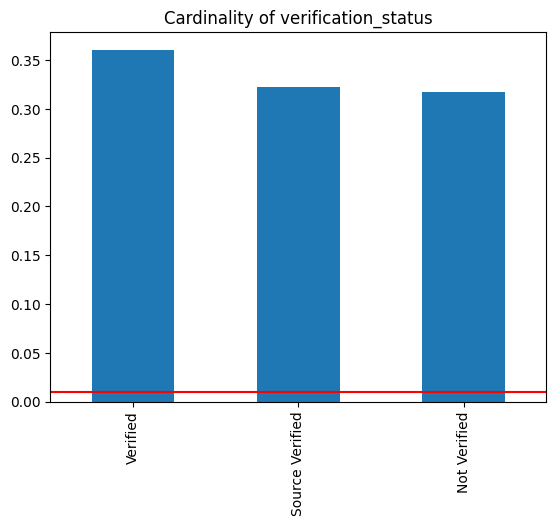

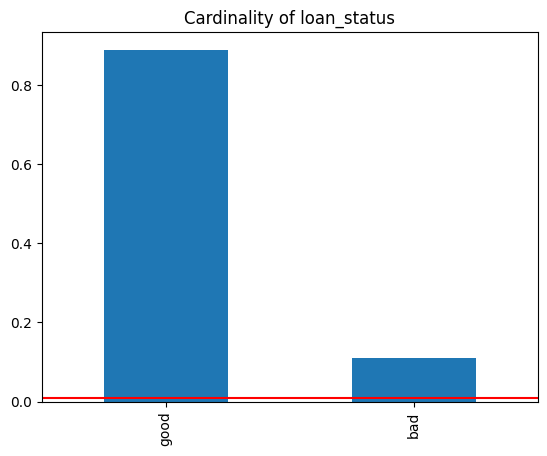

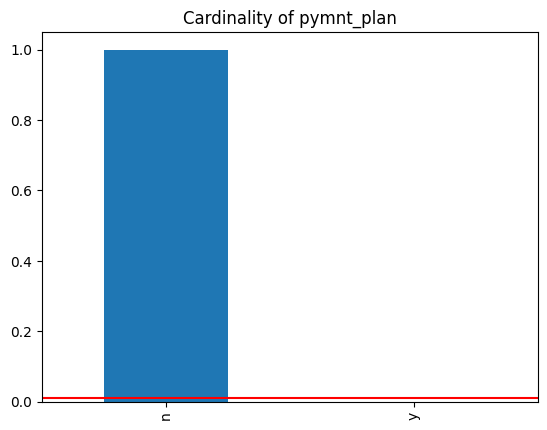

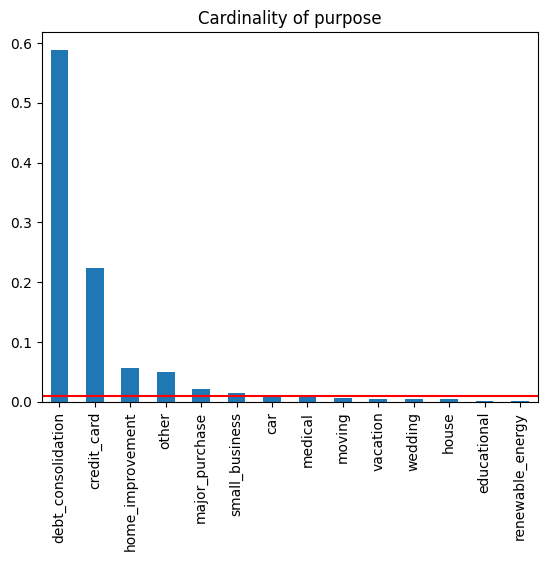

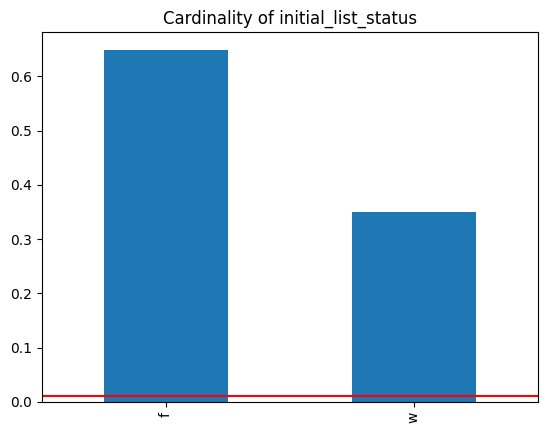

In [83]:
# get variables less than 15 unique valaues
cardinality = (data[vars_cat].nunique() < 15) & (data[vars_cat].nunique() > 1)
card_list = cardinality[cardinality].index

# visualize
for var in card_list:
    detect_rare(data, var)

`pymnt_plan` will be removed.

### Address

In [84]:
data[["zip_code", "addr_state"]]

,zip_code,addr_state
0,860xx,AZ
1,309xx,GA
2,606xx,IL
3,917xx,CA
4,972xx,OR
...,...,...
466280,773xx,TX
466281,377xx,TN
466282,458xx,OH
466283,913xx,CA


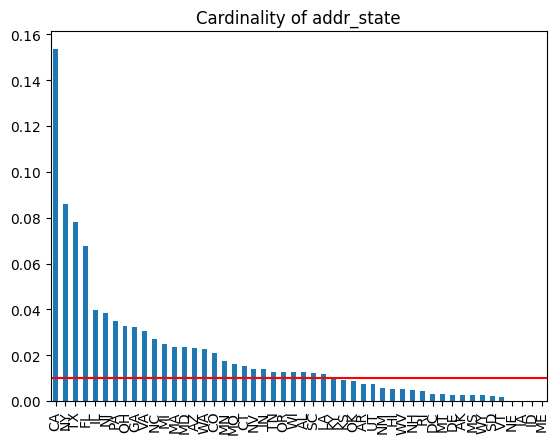

In [85]:
detect_rare(data, "addr_state")

`zip_code` will be removed

### Date Data

In [86]:
date_data = [col for col in vars_cat if col.endswith("_d")]
date_data = date_data + ["earliest_cr_line"]
date_data

['issue_d',
 'last_pymnt_d',
 'next_pymnt_d',
 'last_credit_pull_d',
 'earliest_cr_line']

In [87]:
data[date_data]

,issue_d,last_pymnt_d,next_pymnt_d,last_credit_pull_d,earliest_cr_line
0,11-Dec,15-Jan,NaN,16-Jan,Jan-85
1,11-Dec,13-Apr,NaN,13-Sep,Apr-99
2,11-Dec,14-Jun,NaN,16-Jan,1-Nov
3,11-Dec,15-Jan,NaN,15-Jan,Feb-96
4,11-Dec,16-Jan,16-Feb,16-Jan,Jan-96
...,...,...,...,...,...
466280,14-Jan,16-Jan,16-Feb,16-Jan,3-Apr
466281,14-Jan,14-Dec,NaN,16-Jan,Jun-97
466282,14-Jan,16-Jan,16-Feb,15-Dec,1-Dec
466283,14-Jan,14-Dec,NaN,15-Apr,3-Feb


In [91]:
data[date_data].isna().mean()

issue_d               0.000000
last_pymnt_d          0.000818
next_pymnt_d          0.494015
last_credit_pull_d    0.000087
earliest_cr_line      0.000007
dtype: float64

In [88]:
data[date_data].nunique()

issue_d                91
last_pymnt_d           98
next_pymnt_d           72
last_credit_pull_d    102
earliest_cr_line      664
dtype: int64

In [90]:
data[date_data]

,issue_d,last_pymnt_d,next_pymnt_d,last_credit_pull_d,earliest_cr_line
0,11-Dec,15-Jan,NaN,16-Jan,Jan-85
1,11-Dec,13-Apr,NaN,13-Sep,Apr-99
2,11-Dec,14-Jun,NaN,16-Jan,1-Nov
3,11-Dec,15-Jan,NaN,15-Jan,Feb-96
4,11-Dec,16-Jan,16-Feb,16-Jan,Jan-96
...,...,...,...,...,...
466280,14-Jan,16-Jan,16-Feb,16-Jan,3-Apr
466281,14-Jan,14-Dec,NaN,16-Jan,Jun-97
466282,14-Jan,16-Jan,16-Feb,15-Dec,1-Dec
466283,14-Jan,14-Dec,NaN,15-Apr,3-Feb
